In [92]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets
!pip install tensorboard

In [93]:
import pandas as pd
import numpy as np
import random
import joblib
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from data_utils_unlabelled import loadUnlabelledDatafromFile,createTokenizedDfUnlabelled,CompDatasetUnlabelled
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


In [94]:
# consistency_weight = 100.0 # max weights till you want a ramp-up, will be this value after rampup epoch is reached
# consistency_rampup = 1000 # till what epochs rampup is needed

In [102]:
# config = reload(config)

In [95]:

def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

In [96]:
def get_consistency_weight(epoch):
        # Consistency ramp-up from https://arxiv.org/abs/1610.02242
        return config.consistency_weight * sigmoid_rampup(
            epoch, config.consistency_rampup)

In [3]:
def get_consistency_weight(epoch):
        # Consistency ramp-up from https://arxiv.org/abs/1610.02242
        return 1* sigmoid_rampup(
            epoch, 4)

In [43]:
# lst = np.arange(0,10,1)
# for item in lst :
#     print(get_consistency_weight(item))

In [4]:
lst = np.arange(0,5,1)
for item in lst :
    
    print(get_consistency_weight(item))

NameError: name 'np' is not defined

In [91]:
# def ramp_up(epoch, max_epochs, max_val):
#     if epoch == 0:
#         return 0.
#     elif epoch >= max_epochs:
#         return max_val
#     return max_val * np.exp(-5 * (1. - float(epoch) / max_epochs) ** 2)


# def weight_schedule(epoch, max_epochs, max_val, n_labeled, n_samples):
#     max_val = max_val * (float(n_labeled) / n_samples)
#     return ramp_up(epoch, max_epochs, max_val)

In [10]:
# weight_schedule(25, 10, 1.0, 1000, 10000)

In [104]:
#setting seed
def set_seed():
    
    torch.manual_seed(config.random_seed)
    np.random.seed(config.random_seed)
    random.seed(config.random_seed)
    torch.cuda.manual_seed(config.random_seed)
set_seed()    

In [105]:
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard.summary import hparams

class SummaryWriter(SummaryWriter):
    def add_hparams(self, hparam_dict, metric_dict):
        torch._C._log_api_usage_once("tensorboard.logging.add_hparams")
        if type(hparam_dict) is not dict or type(metric_dict) is not dict:
            raise TypeError('hparam_dict and metric_dict should be dictionary.')
        exp, ssi, sei = hparams(hparam_dict, metric_dict)

        logdir = self._get_file_writer().get_logdir()
        
        with SummaryWriter(log_dir=logdir) as w_hp:
            w_hp.file_writer.add_summary(exp)
            w_hp.file_writer.add_summary(ssi)
            w_hp.file_writer.add_summary(sei)
            for k, v in metric_dict.items():
                w_hp.add_scalar(k, v)

In [14]:
# Read the labelled data
# def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
#                  filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
#                  model_type='xlm'):
    
    
#     dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
#     df_train= dataObjTrain.createDf() # get dataframe from files    
#     dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
#     df_eval = dataObjEval.createDf()
#     df_combined = df_train.append(df_eval, ignore_index=True)
#     df_combined.reset_index(drop=True)
#     split_ratio_len = int(len(df_combined) - config.test_split_ratio*len(df_combined))
#     df_train_splitted = df_combined.iloc[:split_ratio_len,:]
#     df_eval_splitted = df_combined.iloc[split_ratio_len:,:]
#     if len(df_eval_splitted) > config.limit_eval_data:
#         len_train_unlabel = len(df_eval_splitted) - config.limit_eval_data # 4800 - 2500 = 2300 
#         df_eval = df_eval_splitted[:config.limit_eval_data] # [:2500]
#         df_unlabelled_train = df_eval_splitted[config.limit_eval_data: len(df_eval_splitted)] # [2500:4800]
#         df_unlabelled_train = df_unlabelled_train.reset_index(drop=True)
#     obj_tokenized_train = createTokenizedDf(df_train_splitted,model_type)
#     obj_tokenized_test = createTokenizedDf(df_eval,model_type)
#     df_new_train = obj_tokenized_train.convertDf()
#     df_new_eval = obj_tokenized_test.convertDf()
#     train_data = CompDataset(df_new_train,model_type)
#     test_data = CompDataset(df_new_eval,model_type)
#     if len(df_eval_splitted) > config.limit_eval_data:
#         return train_data,test_data, df_unlabelled_train
#     else:
#         return train_data,test_data , None


In [158]:
def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
                 filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
                 model_type='xlm'):
    
    
    dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df_train= dataObjTrain.createDf() # get dataframe from files    
    dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
    df_eval = dataObjEval.createDf()
    df_combined = df_train.append(df_eval, ignore_index=True)
    df_combined.reset_index(drop=True)
    split_ratio_len = int(len(df_combined) - config.test_split_ratio*len(df_combined))
    df_train_splitted = df_combined.iloc[:split_ratio_len,:]
    df_eval_splitted = df_combined.iloc[split_ratio_len:,:]
    df_train_splitted_ = df_train_splitted[1600:2100]
    df_unlabel_splitted = df_train_splitted[2100:3600]
    df_unlabel_splitted = df_unlabel_splitted.reset_index(drop=True)
    df_eval_splitted = df_eval_splitted[:1000]
    obj_tokenized_train = createTokenizedDf(df_train_splitted_,model_type)
    obj_tokenized_test = createTokenizedDf(df_eval_splitted,model_type)
    df_new_train = obj_tokenized_train.convertDf()
    df_new_eval = obj_tokenized_test.convertDf()
    train_data = CompDataset(df_new_train,model_type)
    test_data = CompDataset(df_new_eval,model_type)
    return train_data,test_data,df_unlabel_splitted

In [159]:
# # Read the labelled data
# def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
#                  filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,
#                  model_type='xlm'):
    
    
#     dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
#     df_train= dataObjTrain.createDf() # get dataframe from files    
#     df_train = df_train.sample(frac=1).reset_index(drop=True)
#     df_train=df_train.iloc[:500,:]
#     dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
#     df_eval = dataObjEval.createDf()
#     obj_tokenized_train = createTokenizedDf(df_train,model_type)
#     obj_tokenized_test = createTokenizedDf(df_eval,model_type)
#     df_new_train = obj_tokenized_train.convertDf()
#     df_new_eval = obj_tokenized_test.convertDf()
#     train_data = CompDataset(df_new_train,model_type)
#     test_data = CompDataset(df_new_eval,model_type)
#     return train_data,test_data


In [160]:
train_data , eval_data, df_unlabel = process_data_labelled(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,
                                                config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,
                                                config.filePath_tarTags_eval)

In [162]:
len_labelled_data = len(train_data)
len_eval_data = len(eval_data)
print(len_labelled_data)
print(len_eval_data)
len(df_unlabel)

500
1000


1500

In [13]:
# def process_data_unlabelled(filePath_src,filePath_tar,len_train_data,df_unlabelled_train,model_type):
    
#     dataObj = loadUnlabelledDatafromFile(filePath_src,filePath_tar)
#     df= dataObj.createDfUnlabelled() # get dataframe from files
#     df['len_src'] = df['source'].str.split().map(lambda x:len(x))
#     df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
    
#     df = df[df.len_tar != 36]
#     df = df[df.len_tar != 2]
#     df = df[df.len_src != 1]
    
#     df = df.iloc[:,:-2]
#     df = df.reset_index(drop=True)
#     df_unlabelled_train = df_unlabelled_train.iloc[:,:-2]
#     df_new = df.append(df_unlabelled_train, ignore_index = True)
#     len_unlabelled_needed = config.fix_train_size - len_train_data
#     df_new=df_new[:len_unlabelled_needed]
# #     print(df_new)
    
#     obj_tokenized = createTokenizedDfUnlabelled(df_new,model_type)
#     df_unlabelled= obj_tokenized.convertDf()
# #     enc_label = preprocessing.LabelEncoder()
# #     df_new['labels']= enc_label.fit_transform(df_new['labels'])
#     train_data = CompDatasetUnlabelled(df_unlabelled,model_type)
#     return df_new,train_data


In [163]:
def process_data_unlabelled(filePath_src,filePath_tar,df_unlabel, model_type):
    
    dataObj = loadUnlabelledDatafromFile(filePath_src,filePath_tar)
    df= dataObj.createDfUnlabelled() # get dataframe from files
    df['len_src'] = df['source'].str.split().map(lambda x:len(x))
    df['len_tar'] = df['target'].str.split().map(lambda x:len(x))
    
    df = df[df.len_tar != 36]
    df = df[df.len_tar != 2]
    df = df[df.len_src != 1]
    
    df=df.iloc[:,:-2]
#     df=df.iloc[:1000,:]
    df = df[:2000]
    obj_tokenized = createTokenizedDfUnlabelled(df_unlabel,model_type) # change to df for backtranslated data
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDatasetUnlabelled(df_new,model_type)
    return df,train_data

In [164]:
df_unlabelled_train, dataset_train_unlabelled = process_data_unlabelled(config.filePath_src_backtranslated,config.filePath_tar_backtranslated,df_unlabel,
                                                                        model_type = 'xlm')
len_unlabelled_data = len(dataset_train_unlabelled)
len_unlabelled_data

1500

In [165]:
#combining 2 tuples --> labelled and unlabelled data 
combined_Data = train_data + dataset_train_unlabelled
len(combined_Data)

2000

In [113]:
# combined_Data[3100]

In [166]:
# dataloaders
loader_obj = createDataloaders(combined_Data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

125

In [167]:
loader_obj = createDataloaders(eval_data,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [177]:
batch = next(iter(train_dataloader))
print(batch[0][0])
print(batch[1][0])
print(batch[2][0])
# as seen, combination of labelled and unlabelled data in one training batch

tensor([     0,    579, 100034,   6505,   1679,  14432,     45,  19393,   4188,
            47,     70,   1261,  21816,    450,  22008,    879,   6259,  79602,
          1295,     70,  32964, 135451,      7,    321,     56,     70,  17431,
          2412, 115081,  16065,      6,      5,      2,      2,    656,    579,
         73405,    656,   6505,   1679,    656,    493,  65512,    656,  38985,
           656,    168,    656,  61024,  51086,     19,    656,      6,      4,
           656,   1421,    656,  40127,    656,  79602,    656,   1312,    656,
           745,    656,  32964,    656, 135451,      7,    656,  40274,  37720,
           656,     23,    656,    122,    656,  50936,    656,      6,      4,
           656,     68,    656,   1329,    656,   6057,    275,    656, 139471,
           656,      6,      5,    656,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [118]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [119]:
class GaussianNoise(nn.Module):
    
    def __init__(self, stddev):
        
        super().__init__()
        
        self.stddev = stddev

    def forward(self, din):
        
        if self.training:
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        
        return din

In [120]:
# noise = GaussianNoise(0.7)
# print(noise(a))
# print(torch.randn(a.size()) * 0.7 )
# print(torch.autograd.Variable(torch.randn(a.size()).cuda() * 0.7))

In [140]:
class EntityModel(nn.Module):
    
    def __init__(self,std_gaussian=0.1,with_noise_layer = True, dropout_layer=False, dropout_prob = 0.3):
        
        super(EntityModel, self).__init__()
        
        self.std_gaussian = std_gaussian
        self.with_noise_layer = with_noise_layer
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False) # , add_pooling_layer=False
        self.dropout_layer = dropout_layer
        self.dropout_prob = dropout_prob
        if self.with_noise_layer:
            self.noise = GaussianNoise(stddev=self.std_gaussian)
        if self.dropout_layer:
            self.bert_drop_1 = nn.Dropout(self.dropout_prob) # remove this or noise 
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                            attention_mask = attention_mask,
                            return_dict=False)
        
        if (self.with_noise_layer):
            
            noise = self.noise(outputs[0]) # 256*768
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(noise)
                tag = self.out_tag(bo_tag)
            else:
                tag = self.out_tag(noise)
        
        else:
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(outputs[0])
                tag = self.out_tag(bo_tag)
            
            else :
                tag = self.out_tag(outputs[0])
#         tag = self.out_tag(bo_tag) # 256 * 2 
       
        softmax_prob = self.softmax(tag)
        
#         loss_tag = loss_fn(tag,labels,attention_mask)
        
        return softmax_prob,tag
#         return outputs[0], outputs[1]

In [122]:
# model = EntityModel(std_gaussian=config.gaussian_noise_std_student, with_noise_layer=True )
# model.cuda()# print(noise ,embeddings)

In [123]:
# outputs, outputs1 = model(batch[0].cuda(), attention_mask = batch[1].cuda())

In [124]:
# print(outputs,'\n')
# print(outputs1)

In [49]:
writer.add_text('text', '')

In [29]:
# model2 = EntityModel(std_gaussian=config.gaussian_noise_std_teacher)
# model2.cuda()
# outputs, outputs1 = model2(batch[0].cuda(), attention_mask = batch[1].cuda())
# print(outputs,'\n')
# print(outputs1)

In [125]:
def ClassificationCost(output,target,mask):
    
    
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    
    active_labels = torch.where( # just append -100 for the padded tokens so its ignored when computing loss , no need now
        active_loss,             # since its handled in preprocessing only
        target.view(-1),
        torch.tensor(-100).type_as(target)    
    )
    try:
        class_0_weights =1/len(torch.where(active_labels==0)[0]) # trying to weight the labels as its unbalanced mostly
    
    except ZeroDivisionError:
        class_0_weights = 1e-8

    try:
        class_1_weights =1/len(torch.where(active_labels==1)[0])
    
    except:
        class_1_weights = 1e-8
    
    weights_tensor = torch.tensor([class_0_weights,class_1_weights]).cuda()
    lfn = nn.CrossEntropyLoss(weight = weights_tensor)
    loss = lfn(active_logits,active_labels)
    
    return loss

In [32]:
# a = torch.tensor([[0.2,0.5],[0.9,0.4],[0.9,0.2],[0.2,0.9],[0.7,0.4]])
# b = torch.tensor([-100,-100,-100,-100,-100])
# c = torch.tensor([1,1,1,1,1])
# ClassificationCost(a,b,c).item()

In [126]:
def ConsistencyCost(student_output, teacher_output,mask):
    
    assert len(student_output) == len(teacher_output)
    
    loss = nn.MSELoss()
    active_outputs = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    flattened_outputs_student = student_output.view(-1,2)
    flatenned_outputs_teacher = teacher_output.view(-1,2)
    
    # [0.2,0.8] , [0.3,0.7] , [0.9,0.1]
    # [0.7,0.3] , [0.9,0.1] , [0.8,0.2]
    
    
    active_outputs_teacher=flatenned_outputs_teacher[torch.where(active_outputs == 1)]
    active_outputs_student=flattened_outputs_student[torch.where(active_outputs == 1)]
    
    return torch.sqrt(loss(active_outputs_student,active_outputs_teacher))
    

In [30]:
def ConsistencyCost(student_output, teacher_output,mask):
    
    assert len(student_output) == len(teacher_output)
    
    loss = nn.MSELoss()
    active_outputs = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    flattened_outputs_student = student_output.view(-1,2)
    flatenned_outputs_teacher = teacher_output.view(-1,2)
    
    # [0.2,0.8] , [0.3,0.7] , [0.9,0.1] -> s
    # [0.7,0.3] , [0.9,0.1] , [0.8,0.2] -> T 
    
    
    
    pseudo_label = torch.softmax(logits_u_w.detach()/args.T, dim=-1)
    max_probs, targets_u = torch.max(pseudo_label, dim=-1)
    mask = max_probs.ge(config.threshold).float()

    Lu = (F.cross_entropy(logits_u_s, targets_u,
                                  reduction='none') * mask)
    
    active_outputs_teacher=flatenned_outputs_teacher[torch.where(active_outputs == 1)]
    active_outputs_student=flattened_outputs_student[torch.where(active_outputs == 1)]
    
    return torch.sqrt(loss(active_outputs_student,active_outputs_teacher))
    

In [127]:
# Update teacher to be exponential moving average of student params.
def update_teacher_params(student_model, teacher_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    
    teacher_params = teacher_model.parameters()
    student_params = student_model.parameters()
    
    assert sum(p.numel() for p in student_model.parameters()) == sum(p.numel() for p in teacher_model.parameters())
    
    alpha = min(1 - 1 / (global_step + 1), alpha)
    
    for teacher_param, student_param in zip(teacher_params, student_params):
            teacher_param.data.mul_(config.alpha).add_(1 - config.alpha, student_param.data)
    
    return teacher_model

In [171]:
def train(train_dataloader, optimizer,scheduler, student_model, teacher_model ,writer, global_step, epoch):
    
    student_model.train() # put student model in training mode
    total_train_loss = 0
    consistency_cst = 0
    classification_cst=0
    classification_cst_lst = []
    consistency_cst_lst = []
    overall_cst_lst = []
#     global_step = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, total = len(train_dataloader),position = 0 , leave = True)):

        if (student_model.training):
            
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            optimizer.zero_grad()
            
            output_student_softmax, output_student_logit = student_model( b_input_ids, attention_mask = b_input_mask )
            
            with torch.no_grad():
                
                if (teacher_model.training!=True):
                    output_teacher_softmax, _ = teacher_model( b_input_ids, attention_mask = b_input_mask )
                else:
                    print('Teacher is in training mode in current epoch',epoch)
                    break

            classification_cost =  ClassificationCost(output_student_logit,b_labels,b_input_mask)
            classification_cst+=classification_cost.item()
            
            writer.add_scalar('TrainingLoss/Classification', classification_cost.item(), global_step)

            consistency_cost = ConsistencyCost(output_student_softmax,output_teacher_softmax,b_input_mask)
            consistency_cst+=consistency_cost.item()
            
            writer.add_scalar('TrainingLoss/Consistency', consistency_cost.item(), global_step)
            
            overall_cost = (config.ratio * classification_cost) + ((1 - config.ratio) * consistency_cost)
            
#             overall_cost =  classification_cost + get_consistency_weight(epoch) * consistency_cost
            
            writer.add_scalar('TrainingLoss/Overall', overall_cost.item(), global_step)
            
            overall_cost.backward()
            optimizer.step()
            scheduler.step()
            
            total_train_loss+=overall_cost.item()
            
            teacher_model = update_teacher_params(student_model , teacher_model , config.alpha,global_step)

#             with torch.no_grad():
#                 teacher_softmax,_ = teacher_model(b_input_ids, attention_mask = b_input_mask)
            
            if step % 200 == 0 and step!=0:
                print ('train loss : ', total_train_loss/step)
                print('Consistency Cost :', consistency_cst/step)
                print('Classification Cost :', classification_cst/step)
                print('Consistency Weight is:', get_consistency_weight(epoch))
        
        else:
            print('Student model is not in training mode in epoch', epoch)
#             break
        global_step+=1
        
    return (consistency_cst/len(train_dataloader), classification_cst/len(train_dataloader), total_train_loss/len(train_dataloader),global_step)

In [53]:
def soft_frequency(logits, power=2, probs=False):
    """
    Unsupervised Deep Embedding for Clustering Analysis
    https://arxiv.org/abs/1511.06335
    """
    if not probs:
        softmax = torch.nn.Softmax(dim=1)
        y = softmax(logits.view(-1, logits.shape[-1])).view(logits.shape)
    else:
        y = logits
    f = torch.sum(y, dim=(0, 1))
    t = y**power / f
    p = t/torch.sum(t, dim=2, keepdim=True)

    return p

In [79]:
logits = torch.tensor([[[0.3,0.7] , [0.2,0.8] , [0.5569,0.5]]])
f = torch.sum(logits, dim=(0,1))
print(f)
new_logits = soft_frequency(logits,probs = True)
# t = logits**2 / f
# print(t.shape)
# p = t/torch.sum(t, dim=2, keepdim=True)
# p

tensor([1.0569, 2.0000])


In [80]:
softmax = torch.nn.Softmax(dim=1)
y = softmax(new_logits.view(-1, new_logits.shape[-1])).view(new_logits.shape)
y

tensor([[[0.3813, 0.6187],
         [0.3125, 0.6875],
         [0.5993, 0.4007]]])

In [90]:
_confidence = y.max(dim=-1)[0]
_confidence[0]
# torch.where(_confidence[0]>0.5)

(tensor([0, 1, 2]),)

In [129]:
def test( model, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    lst_active_preds = []
    lst_active_labels = []
    with torch.no_grad():
        
        for batch in tqdm(test_loader,total = len(test_loader),position = 0 , leave = True):
            
            b_input_ids_eval = batch[0].cuda()
            b_input_mask_eval = batch[1].cuda()
            b_labels_eval = batch[2].cuda()
            
            _, output= model(b_input_ids_eval,attention_mask = b_input_mask_eval)
            
            classification_cost =  ClassificationCost(output,b_labels_eval,b_input_mask_eval)
            test_loss+=classification_cost
            
            labels = b_labels_eval.view(-1) 
            active_logits = output.view(-1, 2)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            active_accuracy = labels.view(-1) != -100
            labels_tmp = torch.masked_select(labels, active_accuracy) 
            pred_tmp = torch.masked_select(flattened_predictions, active_accuracy) 
            lst_active_labels.extend(labels_tmp.tolist())
            lst_active_preds.extend(pred_tmp.tolist())
            
    avg_f1_score_0=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 0)
    avg_f1_score_1=f1_score(lst_active_labels,lst_active_preds,average='binary',pos_label = 1)
    avg_accuracy_score=accuracy_score(lst_active_labels,lst_active_preds)
    avg_mcc_score = matthews_corrcoef(lst_active_labels,lst_active_preds)
    
    test_loss /= len(test_loader)
    
    print('Overall validation loss:', test_loss)
    print('Average F1 Validation score for whole sentence class 0 :' ,avg_f1_score_0)
    print('Average F1 Validation score for whole sentence class 1 :' ,avg_f1_score_1)
    print('Average Accuracy Validation score whole sentence  :' ,avg_accuracy_score)
    print('Average mcc Validation score whole sentence :' ,avg_mcc_score)
    print('Classification Report :'+'\n', classification_report(lst_active_labels,lst_active_preds))

    return (test_loss, avg_f1_score_0 , avg_f1_score_1, avg_accuracy_score, avg_mcc_score)

In [170]:
def train_MeanTeacher(train_dataloader, val_dataloader,len_labelled_data ,len_unlabelled_data, writer,early_stopping,dropout_layer = False, noise_layer=True):
    
    exp_name = input('Enter Experiment name :')
    model_name = input('Enter name for saving the models with version :')
    
    global_step = 0
    best_mcc_teacher = -1
    best_mcc_student = -1
    # train losses
    epochs_consistency_lst =[]
    epochs_classification_lst = []
    epochs_overall_lst = []
    
    #test metrices for student
    epochs_f1_score_0_lst_student = []
    epochs_f1_score_1_lst_student = []
    epochs_accuracy_lst_student = []
    epochs_mcc_lst_student = []
    epochs_cost_lst_student=[]
    
    #test metrices for teacher
    epochs_f1_score_0_lst_teacher= []
    epochs_f1_score_1_lst_teacher = []
    epochs_accuracy_lst_teacher = []
    epochs_mcc_lst_teacher = []
    epochs_cost_lst_teacher=[]
    
    set_seed()
    #initialaize the language models
    student = EntityModel(std_gaussian=config.gaussian_noise_std_student, with_noise_layer=noise_layer,dropout_layer=dropout_layer) 
    teacher = EntityModel(std_gaussian=config.gaussian_noise_std_teacher, with_noise_layer=noise_layer)
    student.load_state_dict(torch.load('../models/training_data/model_xlmrobertatokenclassificationmodel_verylessData_weightedlss.bin'))
    teacher.load_state_dict(torch.load('../models/training_data/model_xlmrobertatokenclassificationmodel_verylessData_weightedlss.bin'))
    student.cuda() # take model to gpu
    teacher.cuda()
    teacher.eval() # teacher.train()
    param_optimizer_student = list(student.named_parameters())
    param_teacher = list(teacher.named_parameters())
    
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer_student if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer_student if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
    optimizer = AdamW(optimizer_parameters, lr=config.lr)
    num_train_steps = int(len(train_dataloader) * config.EPOCHS)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer, T_max=num_train_steps)
    scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
    set_seed() # setting seed again before training
    
    with open(f'../Logs/{exp_name}.txt', 'w') as f:
        f.write(f'{exp_name}'+'\n')
        for epoch in range(0,config.EPOCHS):
            print(f'Current epoch is {epoch+1} of {config.EPOCHS}')

            consistency_cost , classification_cost , overall_cost, global_step = train(train_dataloader, optimizer,scheduler,student,teacher,writer,global_step,epoch)

            writer.add_scalar('TrainingLoss/Consistency_epoch :', consistency_cost,epoch )
            writer.add_scalar('TrainingLoss/Classification_epoch', classification_cost,epoch)
            writer.add_scalar('TrainingLoss/Overall_epoch',overall_cost,epoch)

            epochs_consistency_lst.append(consistency_cost)
            epochs_classification_lst.append(classification_cost)
            epochs_overall_lst.append(overall_cost)


            print('---------Running validation for student -------------')
            test_loss_student, avg_f1_score_0_student, avg_f1_score_1_student, avg_accuracy_score_student, avg_mcc_score_student = test(student,val_dataloader)

            epochs_f1_score_0_lst_student.append(avg_f1_score_0_student)
            epochs_f1_score_1_lst_student.append(avg_f1_score_1_student)
            epochs_accuracy_lst_student.append(avg_accuracy_score_student)
            epochs_mcc_lst_student.append(avg_mcc_score_student)
            epochs_cost_lst_student.append(test_loss_student)

            writer.add_scalar('mcc_score/Student',avg_mcc_score_student,epoch)
            writer.add_scalar('ValidationLoss/Student',test_loss_student,epoch)


            for name, weight in student.named_parameters():

                if name == 'bert.embeddings.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.0.attention.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.1.attention.output.dense.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.2.output.dense.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.5.attention.self.key.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.9.attention.self.key.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.10.attention.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bbert.encoder.layer.11.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'out_tag.weight':
                    writer.add_histogram(name,weight, epoch)

            if float("{:.2f}".format(avg_mcc_score_student)) >  best_mcc_student :
                    torch.save(teacher.state_dict(), f'../models/MeanTeacher_models/StudentModels/studentModel_{model_name}.bin')
                    best_mcc_student = float("{:.3f}".format(avg_mcc_score_student))

            print('---------Running validation for teacher -------------')

            test_loss_teacher, avg_f1_score_0_teacher, avg_f1_score_1_teacher, avg_accuracy_score_teacher, avg_mcc_score_teacher=test(teacher,val_dataloader)

            epochs_f1_score_0_lst_teacher.append(avg_f1_score_1_teacher)
            epochs_f1_score_1_lst_teacher.append(avg_f1_score_0_teacher)
            epochs_accuracy_lst_teacher.append(avg_accuracy_score_teacher)
            epochs_mcc_lst_teacher.append(avg_mcc_score_teacher)
            epochs_cost_lst_teacher.append(test_loss_teacher)

            writer.add_scalar('mcc_score/Teacher',avg_mcc_score_teacher,epoch)
            writer.add_scalar('ValidationLoss/Teacher',test_loss_teacher,epoch)

            f.write(f"Consistency_loss {epoch+1} : {str(consistency_cost)}" + '\n')
            f.write(f"Classification_loss {epoch+1} : {str(classification_cost)}" + '\n')
            f.write(f"Overall_loss {epoch+1} : {str(overall_cost)}" + '\n')
            f.write(f"'mcc_score/Teacher {epoch+1} : {str(avg_mcc_score_teacher)}" + '\n')
            f.write(f"ValidationLoss/Teacher {epoch+1} : {str(test_loss_teacher)}" + '\n')
            f.write(f"'mcc_score/Student {epoch+1} : {str(avg_mcc_score_student)}" + '\n')
            f.write(f"ValidationLoss/Student {epoch+1} : {str(test_loss_student)}" + '\n')

            for name, weight in teacher.named_parameters():
                if name == 'bert.embeddings.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.0.attention.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.1.attention.output.dense.weight':
                    writer.add_histogram(name,weight, epoch)
                if name =='bert.encoder.layer.2.output.dense.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.5.attention.self.key.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.9.attention.self.key.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bert.encoder.layer.10.attention.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'bbert.encoder.layer.11.output.LayerNorm.weight':
                    writer.add_histogram(name,weight, epoch)
                if name == 'out_tag.weight':
                    writer.add_histogram(name,weight, epoch)


            if float("{:.2f}".format(avg_mcc_score_teacher)) >  best_mcc_teacher :
                    torch.save(teacher.state_dict(), f'../models/MeanTeacher_models/TeacherModels/teacherModel_{model_name}.bin')
                    best_mcc_teacher = float("{:.3f}".format(avg_mcc_score_teacher))        


            if early_stopping.step(float("{:.2f}".format(avg_mcc_score_teacher))): #mcc score for early stopping "{:.2f}".format(a_float)
                      break 

            if epoch %5 == 0 :
                writer.add_hparams(
                    { "lr": float(scheduler.get_last_lr()[0]), 
                     "consistency_ratio": float(get_consistency_weight(epoch)) , 
                     "alpha":config.alpha, 
                     "teacher_noise_gaussian_std":config.gaussian_noise_std_teacher,
                     "student_noise_gaussian_std":config.gaussian_noise_std_student,
                     "epoch_current":epoch+1,
                     "labelled_data": len_labelled_data, 
                     "unlabelled_data":len_unlabelled_data 

                    },
                    {
                    "mcc_score_teacher": float(avg_mcc_score_teacher),
                    "loss_teacher": float(test_loss_teacher),
                    "mcc_score_student" : float(avg_mcc_score_student),
                    "loss_student" : float(test_loss_student)
                    },
                )

    writer.flush()  
    writer.close()    
    return (epochs_consistency_lst,epochs_classification_lst,epochs_overall_lst,epochs_f1_score_0_lst_student,epochs_f1_score_1_lst_student,
           epochs_accuracy_lst_student,epochs_mcc_lst_student,epochs_cost_lst_student,epochs_f1_score_0_lst_teacher,epochs_f1_score_1_lst_teacher,
            epochs_accuracy_lst_teacher,epochs_mcc_lst_teacher,epochs_cost_lst_teacher)

In [138]:
# config = reload(config)

In [36]:
MeanTeacher_initWithsuptrainedmodel_withConsistencyRampup_for_5_epochs
MeanTeacher_withConsistencyRampup_for_1500_steps
teacherModel_v1_rampup_const_cost_1500_steps_withDropout
v1_initSupModel_rampup_const_cost_5_epochs_withDropout

In [172]:
writer = SummaryWriter("runs/MeanTeacherTraining_Experiments/with_500_labelled_data_alpha_0.5_dropout_0.995_v6")

In [173]:
writer.add_text('text', 'In this experiment, a pretrained model on 1500 data is used to initialize both teacher and student models. Rmse cost used and labelled and unlabelled data used is 500/1500')

In [174]:
early_stopping = EarlyStopping(patience=10)
metrices = train_MeanTeacher(train_dataloader,val_dataloader,len_labelled_data,len_unlabelled_data,writer, early_stopping,dropout_layer=True, noise_layer=True)

Enter Experiment name : MeanTeacher_initWithsuptrainedmodel_alpha_0.995_ratio_0.5
Enter name for saving the models with version : v1_initSupModel_ratio_0.5_wihtdropout


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are ini

Current epoch is 1 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  9.49it/s]


Overall validation loss: tensor(0.6182, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.386513729579423
Average F1 Validation score for whole sentence class 1 : 0.8783136268054742
Average Accuracy Validation score whole sentence  : 0.7969105082990536
Average mcc Validation score whole sentence : 0.2971817010237133
Classification Report :
               precision    recall  f1-score   support

           0       0.30      0.55      0.39      8039
           1       0.93      0.83      0.88     61487

    accuracy                           0.80     69526
   macro avg       0.62      0.69      0.63     69526
weighted avg       0.86      0.80      0.82     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  9.47it/s]


Overall validation loss: tensor(0.6503, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3900129942454056
Average F1 Validation score for whole sentence class 1 : 0.8881399782135075
Average Accuracy Validation score whole sentence  : 0.810948422173
Average mcc Validation score whole sentence : 0.3001157455094412
Classification Report :
               precision    recall  f1-score   support

           0       0.31      0.52      0.39      8039
           1       0.93      0.85      0.89     61487

    accuracy                           0.81     69526
   macro avg       0.62      0.69      0.64     69526
weighted avg       0.86      0.81      0.83     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 2 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Overall validation loss: tensor(0.6903, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3651506138121248
Average F1 Validation score for whole sentence class 1 : 0.9026302037972478
Average Accuracy Validation score whole sentence  : 0.8311566895837529
Average mcc Validation score whole sentence : 0.2727794159092522
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.42      0.37      8039
           1       0.92      0.88      0.90     61487

    accuracy                           0.83     69526
   macro avg       0.62      0.65      0.63     69526
weighted avg       0.85      0.83      0.84     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Overall validation loss: tensor(0.6632, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3904872614550034
Average F1 Validation score for whole sentence class 1 : 0.8937216019458474
Average Accuracy Validation score whole sentence  : 0.8190029629203464
Average mcc Validation score whole sentence : 0.30040793934551885
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.50      0.39      8039
           1       0.93      0.86      0.89     61487

    accuracy                           0.82     69526
   macro avg       0.62      0.68      0.64     69526
weighted avg       0.86      0.82      0.84     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 3 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  8.98it/s]


Overall validation loss: tensor(0.7056, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38062933778635916
Average F1 Validation score for whole sentence class 1 : 0.9010000917515368
Average Accuracy Validation score whole sentence  : 0.8292868854816903
Average mcc Validation score whole sentence : 0.28964462194504487
Classification Report :
               precision    recall  f1-score   support

           0       0.33      0.45      0.38      8039
           1       0.92      0.88      0.90     61487

    accuracy                           0.83     69526
   macro avg       0.63      0.67      0.64     69526
weighted avg       0.86      0.83      0.84     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  8.94it/s]


Overall validation loss: tensor(0.6773, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38955864323661626
Average F1 Validation score for whole sentence class 1 : 0.8999799122836385
Average Accuracy Validation score whole sentence  : 0.8281218536950206
Average mcc Validation score whole sentence : 0.29972035293579147
Classification Report :
               precision    recall  f1-score   support

           0       0.33      0.47      0.39      8039
           1       0.93      0.87      0.90     61487

    accuracy                           0.83     69526
   macro avg       0.63      0.67      0.64     69526
weighted avg       0.86      0.83      0.84     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 4 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  9.46it/s]


Overall validation loss: tensor(0.7390, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38759990312424314
Average F1 Validation score for whole sentence class 1 : 0.8932242181627776
Average Accuracy Validation score whole sentence  : 0.8181543595201795
Average mcc Validation score whole sentence : 0.29692840277409405
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.50      0.39      8039
           1       0.93      0.86      0.89     61487

    accuracy                           0.82     69526
   macro avg       0.62      0.68      0.64     69526
weighted avg       0.86      0.82      0.83     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  9.46it/s]


Overall validation loss: tensor(0.7318, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3761056992498041
Average F1 Validation score for whole sentence class 1 : 0.908045218252331
Average Accuracy Validation score whole sentence  : 0.8397146391278083
Average mcc Validation score whole sentence : 0.2870876181268096
Classification Report :
               precision    recall  f1-score   support

           0       0.34      0.42      0.38      8039
           1       0.92      0.89      0.91     61487

    accuracy                           0.84     69526
   macro avg       0.63      0.66      0.64     69526
weighted avg       0.85      0.84      0.85     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 5 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  9.15it/s]


Overall validation loss: tensor(1.0414, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.32758259411887963
Average F1 Validation score for whole sentence class 1 : 0.9228203792039124
Average Accuracy Validation score whole sentence  : 0.8615338146880304
Average mcc Validation score whole sentence : 0.25409405872096963
Classification Report :
               precision    recall  f1-score   support

           0       0.37      0.29      0.33      8039
           1       0.91      0.94      0.92     61487

    accuracy                           0.86     69526
   macro avg       0.64      0.61      0.63     69526
weighted avg       0.85      0.86      0.85     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  9.09it/s]


Overall validation loss: tensor(0.8238, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3628613787991104
Average F1 Validation score for whole sentence class 1 : 0.9160535225940877
Average Accuracy Validation score whole sentence  : 0.8516526191640538
Average mcc Validation score whole sentence : 0.2789275365718296
Classification Report :
               precision    recall  f1-score   support

           0       0.36      0.37      0.36      8039
           1       0.92      0.92      0.92     61487

    accuracy                           0.85     69526
   macro avg       0.64      0.64      0.64     69526
weighted avg       0.85      0.85      0.85     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 6 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:14<00:00,  8.89it/s]


Overall validation loss: tensor(1.2573, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2668569989083886
Average F1 Validation score for whole sentence class 1 : 0.9313292906412466
Average Accuracy Validation score whole sentence  : 0.8744210798837845
Average mcc Validation score whole sentence : 0.22394867582508213
Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.20      0.27      8039
           1       0.90      0.96      0.93     61487

    accuracy                           0.87     69526
   macro avg       0.66      0.58      0.60     69526
weighted avg       0.84      0.87      0.85     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:14<00:00,  8.88it/s]


Overall validation loss: tensor(0.9240, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34746848243780754
Average F1 Validation score for whole sentence class 1 : 0.9220811631070932
Average Accuracy Validation score whole sentence  : 0.8607858930472053
Average mcc Validation score whole sentence : 0.271362032372448
Classification Report :
               precision    recall  f1-score   support

           0       0.38      0.32      0.35      8039
           1       0.91      0.93      0.92     61487

    accuracy                           0.86     69526
   macro avg       0.65      0.63      0.63     69526
weighted avg       0.85      0.86      0.86     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 7 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:14<00:00,  8.93it/s]


Overall validation loss: tensor(1.3076, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2927945702785889
Average F1 Validation score for whole sentence class 1 : 0.9290953545232273
Average Accuracy Validation score whole sentence  : 0.8711129649339815
Average mcc Validation score whole sentence : 0.23798605248142954
Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.23      0.29      8039
           1       0.90      0.95      0.93     61487

    accuracy                           0.87     69526
   macro avg       0.65      0.59      0.61     69526
weighted avg       0.85      0.87      0.86     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  8.94it/s]


Overall validation loss: tensor(1.0611, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.32510527080005813
Average F1 Validation score for whole sentence class 1 : 0.9257970274110379
Average Accuracy Validation score whole sentence  : 0.8662946235940512
Average mcc Validation score whole sentence : 0.25765166582932436
Classification Report :
               precision    recall  f1-score   support

           0       0.39      0.28      0.33      8039
           1       0.91      0.94      0.93     61487

    accuracy                           0.87     69526
   macro avg       0.65      0.61      0.63     69526
weighted avg       0.85      0.87      0.86     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 8 of 25


  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 125/125 [00:13<00:00,  9.33it/s]


Overall validation loss: tensor(1.5454, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2591525423728813
Average F1 Validation score for whole sentence class 1 : 0.9313016691289724
Average Accuracy Validation score whole sentence  : 0.874262865690533
Average mcc Validation score whole sentence : 0.21755794791433042
Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.19      0.26      8039
           1       0.90      0.96      0.93     61487

    accuracy                           0.87     69526
   macro avg       0.65      0.58      0.60     69526
weighted avg       0.84      0.87      0.85     69526



  0%|          | 0/125 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 125/125 [00:13<00:00,  9.40it/s]


Overall validation loss: tensor(1.2246, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3006373387222136
Average F1 Validation score for whole sentence class 1 : 0.9286925649438131
Average Accuracy Validation score whole sentence  : 0.8705807899203176
Average mcc Validation score whole sentence : 0.243470236410087
Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.24      0.30      8039
           1       0.91      0.95      0.93     61487

    accuracy                           0.87     69526
   macro avg       0.65      0.60      0.61     69526
weighted avg       0.85      0.87      0.86     69526



  0%|          | 0/125 [00:00<?, ?it/s]

Current epoch is 9 of 25


 98%|█████████▊| 122/125 [01:52<00:02,  1.09it/s]


KeyboardInterrupt: 

In [39]:
metrices

([0.1694122159977754,
  0.0927928839251399,
  0.07892614689966043,
  0.07999764388427139,
  0.08070516357198358,
  0.0799577594610552,
  0.07580250467484197,
  0.07685241247992963,
  0.07149627465444307,
  0.0715797732056429,
  0.06676684902360042,
  0.06682306761232515],
 [0.6054856963952382,
  0.5299651747941971,
  0.4972467408577601,
  0.4507063112904628,
  0.40456871934235095,
  0.3605777753641208,
  0.3135115907154977,
  0.28061536462667086,
  0.2551073833058278,
  0.24000154518832764,
  0.21886559151423474,
  0.20686908586261174],
 [0.6236533303558827,
  0.6340088784694672,
  0.6883879771828652,
  0.6507004225254058,
  0.6063316278159618,
  0.5604721746345361,
  0.5030178522815307,
  0.4727463952327768,
  0.43384806998074055,
  0.4189509786417087,
  0.3857827138900757,
  0.37392675479253135],
 [0.38779061984024277,
  0.41038270206373445,
  0.3928548229944787,
  0.39714755896873283,
  0.3832370364952826,
  0.36978629329403095,
  0.37184750733137834,
  0.36842505899368194,
  0.3524

In [186]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,len_labelled_data,len_unlabelled_data,writer, early_stopping,dropout_layer=True, noise_layer=True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weig

Current epoch is 1 of 30


 17%|█▋        | 201/1200 [01:44<08:44,  1.91it/s]

train loss :  0.6840269237756729
Consistency Cost : 0.24591102257370948
Classification Cost : 0.6798845852911473


 33%|███▎      | 401/1200 [03:30<07:10,  1.86it/s]

train loss :  0.6481676719337702
Consistency Cost : 0.19939730882644655
Classification Cost : 0.6448088518530131


 50%|█████     | 601/1200 [05:18<05:14,  1.90it/s]

train loss :  0.6290294613013976
Consistency Cost : 0.17903795874367157
Classification Cost : 0.6260135913391908


 67%|██████▋   | 801/1200 [07:03<03:30,  1.89it/s]

train loss :  0.6182544086925919
Consistency Cost : 0.16830754838883877
Classification Cost : 0.6154192909225822


 83%|████████▎ | 1001/1200 [08:50<01:48,  1.83it/s]

train loss :  0.6084349631452933
Consistency Cost : 0.16014561277627945
Classification Cost : 0.6057373321950436


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.57it/s]


Overall validation loss: tensor(0.5543, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4218941010091325
Average F1 Validation score for whole sentence class 1 : 0.8672691050378083
Average Accuracy Validation score whole sentence  : 0.7841065234418709
Average mcc Validation score whole sentence : 0.33162734317206516
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.62      0.42     28264
           1       0.94      0.81      0.87    195161

    accuracy                           0.78    223425
   macro avg       0.63      0.72      0.64    223425
weighted avg       0.86      0.78      0.81    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.62it/s]


Overall validation loss: tensor(0.5385, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.42251387641604365
Average F1 Validation score for whole sentence class 1 : 0.8494104568782853
Average Accuracy Validation score whole sentence  : 0.7611144679422625
Average mcc Validation score whole sentence : 0.3395183919367499
Classification Report :
               precision    recall  f1-score   support

           0       0.30      0.69      0.42     28264
           1       0.95      0.77      0.85    195161

    accuracy                           0.76    223425
   macro avg       0.62      0.73      0.64    223425
weighted avg       0.86      0.76      0.80    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 2 of 30


 17%|█▋        | 201/1200 [01:47<09:09,  1.82it/s]

train loss :  0.5611720892880112
Consistency Cost : 0.12633032597601412
Classification Cost : 0.5422052754461766


 33%|███▎      | 401/1200 [03:33<07:00,  1.90it/s]

train loss :  0.5562462484743446
Consistency Cost : 0.12501543086022138
Classification Cost : 0.5374768479913473


 50%|█████     | 601/1200 [05:19<05:19,  1.87it/s]

train loss :  0.5557154391643901
Consistency Cost : 0.1262499299645424
Classification Cost : 0.5367606960237026


 67%|██████▋   | 801/1200 [07:07<03:33,  1.87it/s]

train loss :  0.5508990832301788
Consistency Cost : 0.12685938664712013
Classification Cost : 0.5318528378382326


 83%|████████▎ | 1001/1200 [08:53<01:44,  1.90it/s]

train loss :  0.5485797943659126
Consistency Cost : 0.12770078866928816
Classification Cost : 0.5294072236418724


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:43<00:00,  9.30it/s]


Overall validation loss: tensor(0.5255, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4374632935518544
Average F1 Validation score for whole sentence class 1 : 0.8576444096722722
Average Accuracy Validation score whole sentence  : 0.7727872887993734
Average mcc Validation score whole sentence : 0.35782688660574513
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.70      0.44     28264
           1       0.95      0.78      0.86    195161

    accuracy                           0.77    223425
   macro avg       0.63      0.74      0.65    223425
weighted avg       0.87      0.77      0.80    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.36it/s]


Overall validation loss: tensor(0.5352, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.45089854782673894
Average F1 Validation score for whole sentence class 1 : 0.8802230994024514
Average Accuracy Validation score whole sentence  : 0.8033434038267875
Average mcc Validation score whole sentence : 0.36680010878650526
Classification Report :
               precision    recall  f1-score   support

           0       0.35      0.64      0.45     28264
           1       0.94      0.83      0.88    195161

    accuracy                           0.80    223425
   macro avg       0.64      0.73      0.67    223425
weighted avg       0.87      0.80      0.83    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 3 of 30


 17%|█▋        | 201/1200 [01:45<08:40,  1.92it/s]

train loss :  0.5496814604103565
Consistency Cost : 0.11255875851958991
Classification Cost : 0.4690599010139704


 33%|███▎      | 401/1200 [03:29<06:56,  1.92it/s]

train loss :  0.5531957303732633
Consistency Cost : 0.11669918432831765
Classification Cost : 0.46960854150354864


 50%|█████     | 601/1200 [05:13<05:11,  1.92it/s]

train loss :  0.5533181980500619
Consistency Cost : 0.11784136489033699
Classification Cost : 0.46891290771464506


 67%|██████▋   | 801/1200 [06:58<03:28,  1.91it/s]

train loss :  0.5510118177346885
Consistency Cost : 0.11838029908016325
Classification Cost : 0.4662205092888325


 83%|████████▎ | 1001/1200 [08:42<01:43,  1.92it/s]

train loss :  0.5510335969552398
Consistency Cost : 0.11764467623829841
Classification Cost : 0.4667691874280572


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Overall validation loss: tensor(0.7311, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4131991009198572
Average F1 Validation score for whole sentence class 1 : 0.9211311299367618
Average Accuracy Validation score whole sentence  : 0.8609511021595614
Average mcc Validation score whole sentence : 0.3357309671696928
Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.39      0.41     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.66      0.67    223425
weighted avg       0.85      0.86      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Overall validation loss: tensor(0.6279, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.44651026488448947
Average F1 Validation score for whole sentence class 1 : 0.9117939324437571
Average Accuracy Validation score whole sentence  : 0.8478370817947857
Average mcc Validation score whole sentence : 0.36049186787961107
Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.49      0.45     28264
           1       0.92      0.90      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.67      0.69      0.68    223425
weighted avg       0.86      0.85      0.85    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 4 of 30


 17%|█▋        | 201/1200 [01:44<08:39,  1.92it/s]

train loss :  0.5628368245065212
Consistency Cost : 0.09101066805422306
Classification Cost : 0.3963747537136078


 33%|███▎      | 401/1200 [03:29<06:56,  1.92it/s]

train loss :  0.5825953862629831
Consistency Cost : 0.09303472908213735
Classification Cost : 0.4124312296696007


 50%|█████     | 601/1200 [05:13<05:16,  1.89it/s]

train loss :  0.5849381098834177
Consistency Cost : 0.09268537701418002
Classification Cost : 0.41541293158506354


 67%|██████▋   | 801/1200 [07:01<03:38,  1.83it/s]

train loss :  0.5883344661945011
Consistency Cost : 0.0928415850433521
Classification Cost : 0.4185235773958266


 83%|████████▎ | 1001/1200 [08:47<01:44,  1.90it/s]

train loss :  0.5941983079081401
Consistency Cost : 0.0927313281428069
Classification Cost : 0.42458908328413963


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Overall validation loss: tensor(0.8685, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3662812885845774
Average F1 Validation score for whole sentence class 1 : 0.9298318439989559
Average Accuracy Validation score whole sentence  : 0.8736533512364328
Average mcc Validation score whole sentence : 0.3159058070339356
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.29      0.37     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:43<00:00,  9.27it/s]


Overall validation loss: tensor(0.8202, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.40407732293697207
Average F1 Validation score for whole sentence class 1 : 0.92618749402669
Average Accuracy Validation score whole sentence  : 0.8686449591585543
Average mcc Validation score whole sentence : 0.33672660249232017
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.35      0.40     28264
           1       0.91      0.94      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.65      0.67    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 5 of 30


 17%|█▋        | 201/1200 [01:47<08:43,  1.91it/s]

train loss :  0.5726191497780383
Consistency Cost : 0.07723586943699047
Classification Cost : 0.379529477218166


 33%|███▎      | 401/1200 [03:32<07:01,  1.89it/s]

train loss :  0.5662723982241005
Consistency Cost : 0.07841782694798895
Classification Cost : 0.3702278325613588


 50%|█████     | 601/1200 [05:20<05:30,  1.81it/s]

train loss :  0.5853271516955768
Consistency Cost : 0.08148066617315636
Classification Cost : 0.38162548817073305


 67%|██████▋   | 801/1200 [07:06<03:29,  1.90it/s]

train loss :  0.5870308358815964
Consistency Cost : 0.08149195924575907
Classification Cost : 0.38330093897879125


 83%|████████▎ | 1001/1200 [08:51<01:45,  1.88it/s]

train loss :  0.5920351465670391
Consistency Cost : 0.08216562798945233
Classification Cost : 0.3866210777331144


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(1.1020, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3466261838945031
Average F1 Validation score for whole sentence class 1 : 0.9283961898707774
Average Accuracy Validation score whole sentence  : 0.8709365558912386
Average mcc Validation score whole sentence : 0.29569889343653677
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.61      0.64    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.67it/s]


Overall validation loss: tensor(0.9785, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3804789877993674
Average F1 Validation score for whole sentence class 1 : 0.9280902749158918
Average Accuracy Validation score whole sentence  : 0.8711379657603222
Average mcc Validation score whole sentence : 0.32172260343733866
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.31      0.38     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 6 of 30


 17%|█▋        | 201/1200 [01:46<08:53,  1.87it/s]

train loss :  0.5459050720185041
Consistency Cost : 0.08105942932888865
Classification Cost : 0.343256498510018


 33%|███▎      | 401/1200 [03:34<07:06,  1.87it/s]

train loss :  0.5539185901544988
Consistency Cost : 0.08137020931695588
Classification Cost : 0.35049306652508677


 50%|█████     | 601/1200 [05:20<05:15,  1.90it/s]

train loss :  0.5480685066416239
Consistency Cost : 0.08055849595790884
Classification Cost : 0.3466722663200926


 67%|██████▋   | 801/1200 [07:05<03:34,  1.86it/s]

train loss :  0.5491174371249508
Consistency Cost : 0.08114412841285229
Classification Cost : 0.3462571158495848


 83%|████████▎ | 1001/1200 [08:53<01:45,  1.89it/s]

train loss :  0.5500573833216913
Consistency Cost : 0.08147641498106532
Classification Cost : 0.3463663461266551


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Overall validation loss: tensor(1.1983, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3675654154962288
Average F1 Validation score for whole sentence class 1 : 0.9288092042854404
Average Accuracy Validation score whole sentence  : 0.87202416918429
Average mcc Validation score whole sentence : 0.3135296921175239
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.29      0.37     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:40<00:00,  9.77it/s]


Overall validation loss: tensor(1.1541, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36718140695679297
Average F1 Validation score for whole sentence class 1 : 0.9293509763093539
Average Accuracy Validation score whole sentence  : 0.8728924695087837
Average mcc Validation score whole sentence : 0.3149858271617167
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.29      0.37     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 7 of 30


 17%|█▋        | 201/1200 [01:44<08:39,  1.92it/s]

train loss :  0.5141948902234436
Consistency Cost : 0.07572514432482422
Classification Cost : 0.32488203078508376


 33%|███▎      | 401/1200 [03:28<06:56,  1.92it/s]

train loss :  0.5069515409786254
Consistency Cost : 0.07665460212738254
Classification Cost : 0.31531503586331383


 50%|█████     | 601/1200 [05:13<05:11,  1.92it/s]

train loss :  0.5119268340306977
Consistency Cost : 0.07748242549598217
Classification Cost : 0.3182207705685869


 67%|██████▋   | 801/1200 [06:57<03:28,  1.92it/s]

train loss :  0.5093603189429268
Consistency Cost : 0.07780501997098327
Classification Cost : 0.31484776954865085


 83%|████████▎ | 1001/1200 [08:41<01:43,  1.92it/s]

train loss :  0.5103884511422366
Consistency Cost : 0.07815732325939462
Classification Cost : 0.3149951436370611


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:40<00:00,  9.77it/s]


Overall validation loss: tensor(1.2667, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3336063463833571
Average F1 Validation score for whole sentence class 1 : 0.9295327838225069
Average Accuracy Validation score whole sentence  : 0.8725433590690388
Average mcc Validation score whole sentence : 0.28983635891639764
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.25      0.33     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:40<00:00,  9.77it/s]


Overall validation loss: tensor(1.2340, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.37116967256172295
Average F1 Validation score for whole sentence class 1 : 0.9283830472477452
Average Accuracy Validation score whole sentence  : 0.8714109880273022
Average mcc Validation score whole sentence : 0.3150722673421671
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.30      0.37     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 8 of 30


 17%|█▋        | 201/1200 [01:45<08:47,  1.89it/s]

train loss :  0.46612035698257387
Consistency Cost : 0.07399647776968778
Classification Cost : 0.2811291624978185


 33%|███▎      | 401/1200 [03:31<07:09,  1.86it/s]

train loss :  0.4651099307043478
Consistency Cost : 0.07483679792145267
Classification Cost : 0.2780179355526343


 50%|█████     | 601/1200 [05:18<05:15,  1.90it/s]

train loss :  0.4626752686259958
Consistency Cost : 0.07469186621795719
Classification Cost : 0.2759456026094267


 67%|██████▋   | 801/1200 [07:03<03:30,  1.90it/s]

train loss :  0.46425555654859635
Consistency Cost : 0.07437450658122544
Classification Cost : 0.27831928998508376


 83%|████████▎ | 1001/1200 [08:51<01:48,  1.84it/s]

train loss :  0.47049827568233016
Consistency Cost : 0.07495100677083247
Classification Cost : 0.2831207581408089


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.62it/s]


Overall validation loss: tensor(1.1025, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3924932335615347
Average F1 Validation score for whole sentence class 1 : 0.9230311496159878
Average Accuracy Validation score whole sentence  : 0.8633724963634329
Average mcc Validation score whole sentence : 0.3200526471006992
Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.35      0.39     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.64      0.66    223425
weighted avg       0.85      0.86      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Overall validation loss: tensor(1.2893, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3726459254098539
Average F1 Validation score for whole sentence class 1 : 0.9281276267774788
Average Accuracy Validation score whole sentence  : 0.8710305471634777
Average mcc Validation score whole sentence : 0.31549057901997785
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.30      0.37     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 9 of 30


 17%|█▋        | 201/1200 [01:47<09:03,  1.84it/s]

train loss :  0.42288450511172415
Consistency Cost : 0.06977205293951556
Classification Cost : 0.24845437079202384


 33%|███▎      | 401/1200 [03:34<06:59,  1.91it/s]

train loss :  0.4270412359223701
Consistency Cost : 0.07010387997666839
Classification Cost : 0.25178153469925746


 50%|█████     | 601/1200 [05:19<05:16,  1.89it/s]

train loss :  0.43578857237201496
Consistency Cost : 0.07257901651716869
Classification Cost : 0.2543410302780103


 67%|██████▋   | 801/1200 [07:07<03:38,  1.82it/s]

train loss :  0.4389510146874818
Consistency Cost : 0.07324313302429801
Classification Cost : 0.25584318166511366


 83%|████████▎ | 1001/1200 [08:53<01:44,  1.90it/s]

train loss :  0.4413847975132521
Consistency Cost : 0.07349347479705466
Classification Cost : 0.2576511102577206


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Overall validation loss: tensor(1.4527, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36923143462652996
Average F1 Validation score for whole sentence class 1 : 0.9271906701813243
Average Accuracy Validation score whole sentence  : 0.8694505986348887
Average mcc Validation score whole sentence : 0.30999957314674104
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.30      0.37     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:43<00:00,  9.27it/s]


Overall validation loss: tensor(1.3821, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3626320422535211
Average F1 Validation score for whole sentence class 1 : 0.9278493311078448
Average Accuracy Validation score whole sentence  : 0.8703726082578046
Average mcc Validation score whole sentence : 0.3066032390478674
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.29      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 10 of 30


 17%|█▋        | 201/1200 [01:46<08:43,  1.91it/s]

train loss :  0.40631423344137146
Consistency Cost : 0.06571367501222994
Classification Cost : 0.24203004538896494


 33%|███▎      | 401/1200 [03:30<06:55,  1.92it/s]

train loss :  0.41053757441346533
Consistency Cost : 0.06741118146310328
Classification Cost : 0.24200962038186843


 50%|█████     | 601/1200 [05:15<05:11,  1.92it/s]

train loss :  0.4045443714452752
Consistency Cost : 0.06659559818721997
Classification Cost : 0.23805537577912522


 67%|██████▋   | 801/1200 [06:59<03:27,  1.92it/s]

train loss :  0.406092738553416
Consistency Cost : 0.06662150772048335
Classification Cost : 0.2395389693006291


 83%|████████▎ | 1001/1200 [08:43<01:43,  1.92it/s]

train loss :  0.4065358070470393
Consistency Cost : 0.06724241703003644
Classification Cost : 0.2384297647876665


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


Overall validation loss: tensor(1.3859, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3689249212988917
Average F1 Validation score for whole sentence class 1 : 0.9269162388381709
Average Accuracy Validation score whole sentence  : 0.8690030211480363
Average mcc Validation score whole sentence : 0.3089751556810491
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.30      0.37     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Overall validation loss: tensor(1.4819, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35677368833202816
Average F1 Validation score for whole sentence class 1 : 0.9285126381619028
Average Accuracy Validation score whole sentence  : 0.8713259483048003
Average mcc Validation score whole sentence : 0.3040527617666452
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.28      0.36     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 11 of 30


 17%|█▋        | 201/1200 [01:44<08:40,  1.92it/s]

train loss :  0.37014790452318264
Consistency Cost : 0.06195027026347816
Classification Cost : 0.2152722284081392


 33%|███▎      | 401/1200 [03:29<06:56,  1.92it/s]

train loss :  0.3612258070008829
Consistency Cost : 0.06100286159809912
Classification Cost : 0.20871865225373767


 50%|█████     | 601/1200 [05:13<05:14,  1.91it/s]

train loss :  0.3671964120150854
Consistency Cost : 0.06299068479779332
Classification Cost : 0.2097196994489059


 67%|██████▋   | 801/1200 [06:59<03:33,  1.87it/s]

train loss :  0.3685900548056816
Consistency Cost : 0.06340402483689105
Classification Cost : 0.21007999245310202


 83%|████████▎ | 1001/1200 [08:47<01:45,  1.89it/s]

train loss :  0.3703663169259671
Consistency Cost : 0.0640534841126937
Classification Cost : 0.21023260643379763


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(1.5152, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.37376357692713275
Average F1 Validation score for whole sentence class 1 : 0.9256624982788189
Average Accuracy Validation score whole sentence  : 0.8671008168289135
Average mcc Validation score whole sentence : 0.3096633100263395
Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.31      0.37     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.50it/s]


Overall validation loss: tensor(1.5763, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36460441784739944
Average F1 Validation score for whole sentence class 1 : 0.928051460146787
Average Accuracy Validation score whole sentence  : 0.8707396217970236
Average mcc Validation score whole sentence : 0.3088031692654952
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.29      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 12 of 30


 17%|█▋        | 201/1200 [01:48<08:47,  1.89it/s]

train loss :  0.3673159764212323
Consistency Cost : 0.06629824345029192
Classification Cost : 0.20157036730786784


 33%|███▎      | 401/1200 [03:34<07:01,  1.89it/s]

train loss :  0.3617587848476251
Consistency Cost : 0.06506046386210074
Classification Cost : 0.19910762445128058


 50%|█████     | 601/1200 [05:20<05:22,  1.86it/s]

train loss :  0.3585398203671987
Consistency Cost : 0.06440500655196957
Classification Cost : 0.19752730376378166


 67%|██████▋   | 801/1200 [07:08<03:30,  1.89it/s]

train loss :  0.36066361515855533
Consistency Cost : 0.06464600714494736
Classification Cost : 0.19904859675836634


 83%|████████▎ | 1001/1200 [08:53<01:45,  1.90it/s]

train loss :  0.35749245168303606
Consistency Cost : 0.063750298003637
Classification Cost : 0.19811670637177303


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:43<00:00,  9.20it/s]


Overall validation loss: tensor(1.7866, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3544415127528584
Average F1 Validation score for whole sentence class 1 : 0.9268505369110795
Average Accuracy Validation score whole sentence  : 0.868591249860132
Average mcc Validation score whole sentence : 0.2969834998964942
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.29      0.35     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.52it/s]


Overall validation loss: tensor(1.7586, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35114333020092175
Average F1 Validation score for whole sentence class 1 : 0.9278886800147206
Average Accuracy Validation score whole sentence  : 0.8702025288128007
Average mcc Validation score whole sentence : 0.2975681512314785
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.28      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.85    223425

terminating because of early stopping!


In [160]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,len_labelled_data,len_unlabelled_data,writer, early_stopping,dropout_layer=True, noise_layer=True) # alpha = 0.995 and full data w/o noise and dropout

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weig

Current epoch is 1 of 30


 17%|█▋        | 201/1200 [01:44<08:43,  1.91it/s]

train loss :  0.7983270974457264
Consistency Cost : 1.2331784641742707
Classification Cost : 0.7152361896634102


 33%|███▎      | 401/1200 [03:30<07:07,  1.87it/s]

train loss :  0.7473308978229761
Consistency Cost : 1.0527608996629716
Classification Cost : 0.6763964293897152


 50%|█████     | 601/1200 [05:18<05:16,  1.89it/s]

train loss :  0.7212687063900133
Consistency Cost : 0.9733417272567749
Classification Cost : 0.6556854599714279


 67%|██████▋   | 801/1200 [07:03<03:30,  1.90it/s]

train loss :  0.7056129083177075
Consistency Cost : 0.9237081730365753
Classification Cost : 0.6433739440143108


 83%|████████▎ | 1001/1200 [08:49<01:46,  1.86it/s]

train loss :  0.6936781307868659
Consistency Cost : 0.8928149867653846
Classification Cost : 0.6335207329392433


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.67it/s]


Overall validation loss: tensor(0.5810, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.42292772841068527
Average F1 Validation score for whole sentence class 1 : 0.8878744467489148
Average Accuracy Validation score whole sentence  : 0.8122322927156764
Average mcc Validation score whole sentence : 0.32895516070935754
Classification Report :
               precision    recall  f1-score   support

           0       0.35      0.54      0.42     28264
           1       0.93      0.85      0.89    195161

    accuracy                           0.81    223425
   macro avg       0.64      0.70      0.66    223425
weighted avg       0.85      0.81      0.83    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.72it/s]


Overall validation loss: tensor(0.5483, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4292617356339154
Average F1 Validation score for whole sentence class 1 : 0.86339595010997
Average Accuracy Validation score whole sentence  : 0.7795546604005819
Average mcc Validation score whole sentence : 0.3433128864836653
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.66      0.43     28264
           1       0.94      0.80      0.86    195161

    accuracy                           0.78    223425
   macro avg       0.63      0.73      0.65    223425
weighted avg       0.86      0.78      0.81    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 2 of 30


 17%|█▋        | 201/1200 [01:46<09:01,  1.84it/s]

train loss :  0.6882479389756918
Consistency Cost : 0.6981924873590469
Classification Cost : 0.566606223359704


 33%|███▎      | 401/1200 [03:33<07:00,  1.90it/s]

train loss :  0.6877801588363945
Consistency Cost : 0.7339201067388058
Classification Cost : 0.5599138440564275


 50%|█████     | 601/1200 [05:18<05:18,  1.88it/s]

train loss :  0.6874203920985261
Consistency Cost : 0.7274214905003706
Classification Cost : 0.5606862910091877


 67%|██████▋   | 801/1200 [07:06<03:40,  1.81it/s]

train loss :  0.6802716743107885
Consistency Cost : 0.715478600114584
Classification Cost : 0.555618308186531


 83%|████████▎ | 1001/1200 [08:52<01:44,  1.91it/s]

train loss :  0.6735877949297429
Consistency Cost : 0.6967547527551651
Classification Cost : 0.5521965679824352


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


Overall validation loss: tensor(0.5561, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.45046109239298227
Average F1 Validation score for whole sentence class 1 : 0.8900532559157572
Average Accuracy Validation score whole sentence  : 0.8167662526574914
Average mcc Validation score whole sentence : 0.3632915718011
Classification Report :
               precision    recall  f1-score   support

           0       0.36      0.59      0.45     28264
           1       0.94      0.85      0.89    195161

    accuracy                           0.82    223425
   macro avg       0.65      0.72      0.67    223425
weighted avg       0.86      0.82      0.83    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:40<00:00,  9.79it/s]


Overall validation loss: tensor(0.5646, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.45437953662036584
Average F1 Validation score for whole sentence class 1 : 0.8955856593249849
Average Accuracy Validation score whole sentence  : 0.8247152288239902
Average mcc Validation score whole sentence : 0.3672836535455981
Classification Report :
               precision    recall  f1-score   support

           0       0.37      0.58      0.45     28264
           1       0.93      0.86      0.90    195161

    accuracy                           0.82    223425
   macro avg       0.65      0.72      0.67    223425
weighted avg       0.86      0.82      0.84    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 3 of 30


 17%|█▋        | 201/1200 [01:44<08:41,  1.92it/s]

train loss :  0.6841030767932534
Consistency Cost : 0.46284014262259005
Classification Cost : 0.4954392351955175


 33%|███▎      | 401/1200 [03:29<06:57,  1.92it/s]

train loss :  0.6851914279721677
Consistency Cost : 0.4566898429393768
Classification Cost : 0.4990345843322575


 50%|█████     | 601/1200 [05:13<05:12,  1.92it/s]

train loss :  0.6866159621998668
Consistency Cost : 0.4570451590480904
Classification Cost : 0.5003142840011666


 67%|██████▋   | 801/1200 [06:57<03:27,  1.92it/s]

train loss :  0.6893396806064993
Consistency Cost : 0.4611090247007087
Classification Cost : 0.5013814804959111


 83%|████████▎ | 1001/1200 [08:41<01:43,  1.92it/s]

train loss :  0.6931139895869419
Consistency Cost : 0.4602014200799167
Classification Cost : 0.5055257487203926


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.74it/s]


Overall validation loss: tensor(0.8795, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.36488063184347513
Average F1 Validation score for whole sentence class 1 : 0.9296364241999393
Average Accuracy Validation score whole sentence  : 0.8733087165715564
Average mcc Validation score whole sentence : 0.31415208051339666
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.29      0.36     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.65    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.69it/s]


Overall validation loss: tensor(0.7300, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.417153155976962
Average F1 Validation score for whole sentence class 1 : 0.9248314822487899
Average Accuracy Validation score whole sentence  : 0.8668367461116706
Average mcc Validation score whole sentence : 0.3455031948114302
Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.38      0.42     28264
           1       0.91      0.94      0.92    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.66      0.67    223425
weighted avg       0.86      0.87      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 4 of 30


 17%|█▋        | 201/1200 [01:46<08:56,  1.86it/s]

train loss :  0.8053608505986631
Consistency Cost : 0.38970441950485113
Classification Cost : 0.46907094029709695


 33%|███▎      | 401/1200 [03:34<07:01,  1.90it/s]

train loss :  0.8420703831221908
Consistency Cost : 0.4001398016046733
Classification Cost : 0.49677540846634655


 50%|█████     | 601/1200 [05:19<05:15,  1.90it/s]

train loss :  0.8474677528068423
Consistency Cost : 0.39465750521359344
Classification Cost : 0.5069036468894531


 67%|██████▋   | 801/1200 [07:06<03:35,  1.85it/s]

train loss :  0.8463888318056706
Consistency Cost : 0.38899790358380415
Classification Cost : 0.5107085994794034


 83%|████████▎ | 1001/1200 [08:53<01:45,  1.89it/s]

train loss :  0.8454840100761503
Consistency Cost : 0.38073445626627656
Classification Cost : 0.5169346023108811


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.54it/s]


Overall validation loss: tensor(0.9785, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.30681364724660815
Average F1 Validation score for whole sentence class 1 : 0.931668772771749
Average Accuracy Validation score whole sentence  : 0.8756003133042408
Average mcc Validation score whole sentence : 0.2798239985272208
Classification Report :
               precision    recall  f1-score   support

           0       0.52      0.22      0.31     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.59      0.62    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.42it/s]


Overall validation loss: tensor(0.9595, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34097936291076436
Average F1 Validation score for whole sentence class 1 : 0.9321327280940145
Average Accuracy Validation score whole sentence  : 0.8769385699899295
Average mcc Validation score whole sentence : 0.30620818951163403
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.25      0.34     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.61      0.64    223425
weighted avg       0.85      0.88      0.86    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 5 of 30


 17%|█▋        | 201/1200 [01:47<08:47,  1.89it/s]

train loss :  1.1677834744937718
Consistency Cost : 0.37507117955945435
Classification Cost : 0.5477949746698141


 33%|███▎      | 401/1200 [03:33<07:01,  1.89it/s]

train loss :  1.124707683818415
Consistency Cost : 0.3574998383456841
Classification Cost : 0.533764416212216


 50%|█████     | 601/1200 [05:20<05:27,  1.83it/s]

train loss :  1.1190392184381683
Consistency Cost : 0.34167511636856945
Classification Cost : 0.5542540407398094


 67%|██████▋   | 801/1200 [07:07<03:29,  1.91it/s]

train loss :  1.102465039230883
Consistency Cost : 0.3294504356908146
Classification Cost : 0.5578871226590126


 83%|████████▎ | 1001/1200 [08:51<01:44,  1.91it/s]

train loss :  1.1050440492480993
Consistency Cost : 0.3226883237892762
Classification Cost : 0.5716438291687518


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.73it/s]


Overall validation loss: tensor(1.0958, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27142666844278673
Average F1 Validation score for whole sentence class 1 : 0.9331883757008661
Average Accuracy Validation score whole sentence  : 0.8776009846704711
Average mcc Validation score whole sentence : 0.2647339896596084
Classification Report :
               precision    recall  f1-score   support

           0       0.55      0.18      0.27     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.72      0.58      0.60    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.73it/s]


Overall validation loss: tensor(1.1365, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2780870579502677
Average F1 Validation score for whole sentence class 1 : 0.9334389237598014
Average Accuracy Validation score whole sentence  : 0.8781156987803513
Average mcc Validation score whole sentence : 0.27073408496865853
Classification Report :
               precision    recall  f1-score   support

           0       0.55      0.19      0.28     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.72      0.58      0.61    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 6 of 30


 17%|█▋        | 201/1200 [01:44<08:40,  1.92it/s]

train loss :  1.4161042664200068
Consistency Cost : 0.27788306307047606
Classification Cost : 0.6199559737928212


 33%|███▎      | 401/1200 [03:28<06:55,  1.92it/s]

train loss :  1.442779240021482
Consistency Cost : 0.2837202376453206
Classification Cost : 0.629907159213908


 50%|█████     | 601/1200 [05:12<05:11,  1.92it/s]

train loss :  1.4560522090333203
Consistency Cost : 0.28729500017439324
Classification Cost : 0.6329382622754202


 67%|██████▋   | 801/1200 [06:57<03:27,  1.92it/s]

train loss :  1.4480053487233817
Consistency Cost : 0.28388053392292933
Classification Cost : 0.6346740130032412


 83%|████████▎ | 1001/1200 [08:41<01:43,  1.92it/s]

train loss :  1.459800494838506
Consistency Cost : 0.28658053346537055
Classification Cost : 0.6387335310336202


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.71it/s]


Overall validation loss: tensor(1.2622, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.27149226330972986
Average F1 Validation score for whole sentence class 1 : 0.93203660207477
Average Accuracy Validation score whole sentence  : 0.8756719257021371
Average mcc Validation score whole sentence : 0.25742540393252417
Classification Report :
               precision    recall  f1-score   support

           0       0.52      0.18      0.27     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.58      0.60    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(1.2958, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2594953806256416
Average F1 Validation score for whole sentence class 1 : 0.9331140564914403
Average Accuracy Validation score whole sentence  : 0.877310059304017
Average mcc Validation score whole sentence : 0.2564556501169726
Classification Report :
               precision    recall  f1-score   support

           0       0.55      0.17      0.26     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.72      0.57      0.60    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 7 of 30


 17%|█▋        | 201/1200 [01:48<09:07,  1.83it/s]

train loss :  1.9023063045740127
Consistency Cost : 0.264754075165838
Classification Cost : 0.7126896002236753


 33%|███▎      | 401/1200 [03:33<06:59,  1.90it/s]

train loss :  1.93036342211999
Consistency Cost : 0.2679482451057993
Classification Cost : 0.7263943880633451


 50%|█████     | 601/1200 [05:19<05:18,  1.88it/s]

train loss :  1.8997974702777962
Consistency Cost : 0.2595846816323077
Classification Cost : 0.7334083498843635


 67%|██████▋   | 801/1200 [07:07<03:33,  1.86it/s]

train loss :  1.8818536230688914
Consistency Cost : 0.25674463214934806
Classification Cost : 0.7282256678817793


 83%|████████▎ | 1001/1200 [08:52<01:44,  1.91it/s]

train loss :  1.9058832818083464
Consistency Cost : 0.2617369745308533
Classification Cost : 0.7298232881268486


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.37it/s]


Overall validation loss: tensor(1.3983, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.26963867470196584
Average F1 Validation score for whole sentence class 1 : 0.9321195252060042
Average Accuracy Validation score whole sentence  : 0.8757838200738502
Average mcc Validation score whole sentence : 0.25666953225504263
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.18      0.27     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.58      0.60    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:43<00:00,  9.22it/s]


Overall validation loss: tensor(1.4184, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.24407263935822412
Average F1 Validation score for whole sentence class 1 : 0.9329639835205663
Average Accuracy Validation score whole sentence  : 0.876849054492559
Average mcc Validation score whole sentence : 0.24533004527891467
Classification Report :
               precision    recall  f1-score   support

           0       0.55      0.16      0.24     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.72      0.57      0.59    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 8 of 30


 17%|█▋        | 201/1200 [01:46<08:47,  1.89it/s]

train loss :  2.358029465302825
Consistency Cost : 0.24749842239543796
Classification Cost : 0.7799097978742793


 33%|███▎      | 401/1200 [03:31<07:07,  1.87it/s]

train loss :  2.358616612814367
Consistency Cost : 0.24505481011234223
Classification Cost : 0.7960781087703072


 50%|█████     | 601/1200 [05:20<05:17,  1.89it/s]

train loss :  2.377977109476924
Consistency Cost : 0.2468390863078336
Classification Cost : 0.8040615584809954


 67%|██████▋   | 801/1200 [07:05<03:30,  1.89it/s]

train loss :  2.3984864671621473
Consistency Cost : 0.2489857604156714
Classification Cost : 0.8108831202017609


 83%|████████▎ | 1001/1200 [08:52<01:47,  1.85it/s]

train loss :  2.397256595171988
Consistency Cost : 0.24661322783306242
Classification Cost : 0.8247811825247482


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(1.4209, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.22753128555176338
Average F1 Validation score for whole sentence class 1 : 0.9322340443659006
Average Accuracy Validation score whole sentence  : 0.8753989034351572
Average mcc Validation score whole sentence : 0.22895589814957276
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.15      0.23     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.56      0.58    223425
weighted avg       0.84      0.88      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(1.4974, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2365775047519352
Average F1 Validation score for whole sentence class 1 : 0.9324977042935191
Average Accuracy Validation score whole sentence  : 0.8759628510685913
Average mcc Validation score whole sentence : 0.23696050544617553
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.15      0.24     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.57      0.58    223425
weighted avg       0.84      0.88      0.84    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 9 of 30


 17%|█▋        | 201/1200 [01:46<08:58,  1.85it/s]

train loss :  2.800782269462943
Consistency Cost : 0.23861370355822145
Classification Cost : 0.8471785327373073


 33%|███▎      | 401/1200 [03:34<07:00,  1.90it/s]

train loss :  2.8031363226100803
Consistency Cost : 0.23507021650671958
Classification Cost : 0.8785442073806189


 50%|█████     | 601/1200 [05:19<05:12,  1.92it/s]

train loss :  2.8207591391106446
Consistency Cost : 0.23801803761317084
Classification Cost : 0.8720323067344725


 67%|██████▋   | 801/1200 [07:03<03:27,  1.92it/s]

train loss :  2.8316544649377464
Consistency Cost : 0.23911143160425127
Classification Cost : 0.8739756789861712


 83%|████████▎ | 1001/1200 [08:47<01:43,  1.92it/s]

train loss :  2.8352274618446827
Consistency Cost : 0.23802751085534693
Classification Cost : 0.8864230687301606


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.53it/s]


Overall validation loss: tensor(1.4934, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.22982779161702585
Average F1 Validation score for whole sentence class 1 : 0.9306105123463717
Average Accuracy Validation score whole sentence  : 0.8726910596397002
Average mcc Validation score whole sentence : 0.21945568528795364
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.15      0.23     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.56      0.58    223425
weighted avg       0.84      0.87      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.38it/s]


Overall validation loss: tensor(1.5525, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.22211188348229063
Average F1 Validation score for whole sentence class 1 : 0.9313196849473208
Average Accuracy Validation score whole sentence  : 0.87378314870762
Average mcc Validation score whole sentence : 0.21867412137673936
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.14      0.22     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.56      0.58    223425
weighted avg       0.84      0.87      0.84    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 10 of 30


 17%|█▋        | 201/1200 [01:47<08:45,  1.90it/s]

train loss :  3.0023110722377897
Consistency Cost : 0.2143645025137812
Classification Cost : 0.9632129353377968


 33%|███▎      | 401/1200 [03:33<07:01,  1.89it/s]

train loss :  3.0692429984919727
Consistency Cost : 0.22446560265496374
Classification Cost : 0.9340602325554938


 50%|█████     | 601/1200 [05:20<05:29,  1.82it/s]

train loss :  3.08385130080084
Consistency Cost : 0.22592847062895696
Classification Cost : 0.9347533007043725


 67%|██████▋   | 801/1200 [07:07<03:30,  1.90it/s]

train loss :  3.0861577300168572
Consistency Cost : 0.22728372906683944
Classification Cost : 0.9241681129729841


 83%|████████▎ | 1001/1200 [08:52<01:45,  1.89it/s]

train loss :  3.0821569912210105
Consistency Cost : 0.2258107487987727
Classification Cost : 0.9341787958713248


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.47it/s]


Overall validation loss: tensor(1.6494, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2354344387688957
Average F1 Validation score for whole sentence class 1 : 0.9277780363130476
Average Accuracy Validation score whole sentence  : 0.8680228264518295
Average mcc Validation score whole sentence : 0.2077860426011694
Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.16      0.24     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.57      0.58    223425
weighted avg       0.83      0.87      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(1.6226, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.2279419553013452
Average F1 Validation score for whole sentence class 1 : 0.9287289225248482
Average Accuracy Validation score whole sentence  : 0.8695043079333109
Average mcc Validation score whole sentence : 0.2070133089502458
Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.15      0.23     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.56      0.58    223425
weighted avg       0.83      0.87      0.84    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 11 of 30


 17%|█▋        | 201/1200 [01:46<08:51,  1.88it/s]

train loss :  3.143702931925654
Consistency Cost : 0.21273123817052692
Classification Cost : 1.0163905588677153


 33%|███▎      | 401/1200 [03:34<07:15,  1.83it/s]

train loss :  3.0211665841564534
Consistency Cost : 0.20348322016885503
Classification Cost : 0.9863343919441104


 50%|█████     | 601/1200 [05:19<05:14,  1.90it/s]

train loss :  3.0565687971065443
Consistency Cost : 0.20629561447693656
Classification Cost : 0.9936126605281607


 67%|██████▋   | 801/1200 [07:05<03:33,  1.87it/s]

train loss :  3.034253084696829
Consistency Cost : 0.20423854530090466
Classification Cost : 0.9918676385877189


 83%|████████▎ | 1001/1200 [08:53<01:45,  1.88it/s]

train loss :  3.0722734584063294
Consistency Cost : 0.20853757390286773
Classification Cost : 0.9868977246452123


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.58it/s]


Overall validation loss: tensor(1.6337, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.24460395031561802
Average F1 Validation score for whole sentence class 1 : 0.9271816312610107
Average Accuracy Validation score whole sentence  : 0.8671679534519414
Average mcc Validation score whole sentence : 0.21202125062817043
Classification Report :
               precision    recall  f1-score   support

           0       0.44      0.17      0.24     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.57      0.59    223425
weighted avg       0.83      0.87      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.50it/s]


Overall validation loss: tensor(1.6543, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.23950225184182442
Average F1 Validation score for whole sentence class 1 : 0.9284761174918041
Average Accuracy Validation score whole sentence  : 0.869249188765805
Average mcc Validation score whole sentence : 0.21442024760996276
Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.16      0.24     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.57      0.58    223425
weighted avg       0.83      0.87      0.84    223425



  0%|          | 0/1200 [00:00<?, ?it/s]

Current epoch is 12 of 30


 17%|█▋        | 201/1200 [01:48<08:52,  1.88it/s]

train loss :  3.0264842312037943
Consistency Cost : 0.20198867057450115
Classification Cost : 1.0065975289326161


 33%|███▎      | 401/1200 [03:34<07:01,  1.89it/s]

train loss :  3.0256127504445613
Consistency Cost : 0.2027452050265856
Classification Cost : 0.9981607002671808


 50%|█████     | 601/1200 [05:20<05:21,  1.86it/s]

train loss :  3.043318718311687
Consistency Cost : 0.20324351152870804
Classification Cost : 1.0108836037230988


 67%|██████▋   | 801/1200 [07:08<03:30,  1.90it/s]

train loss :  3.0638284090999512
Consistency Cost : 0.20475811055279336
Classification Cost : 1.0162473054148722


 83%|████████▎ | 1001/1200 [08:53<01:44,  1.90it/s]

train loss :  3.094936975494027
Consistency Cost : 0.20872139790281655
Classification Cost : 1.0077229980537667


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:43<00:00,  9.20it/s]


Overall validation loss: tensor(1.6575, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.23362411603778452
Average F1 Validation score for whole sentence class 1 : 0.9272391351224197
Average Accuracy Validation score whole sentence  : 0.867096341054045
Average mcc Validation score whole sentence : 0.2037575087651301
Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.16      0.23     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.66      0.56      0.58    223425
weighted avg       0.83      0.87      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Overall validation loss: tensor(1.6328, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.23712412860264281
Average F1 Validation score for whole sentence class 1 : 0.9281891059386983
Average Accuracy Validation score whole sentence  : 0.8687344746559248
Average mcc Validation score whole sentence : 0.21114410233431177
Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.16      0.24     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.67      0.57      0.58    223425
weighted avg       0.83      0.87      0.84    223425

terminating because of early stopping!


In [ ]:
consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

In [86]:
# # model= EntityModel()
# optimizer_parameters_model = list(model.named_parameters())
  
# no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
# optimizer_parameters = [
# {
#     "params": [
#         p for n, p in optimizer_parameters_model if not any(nd in n for nd in no_decay)
#     ],
#     "weight_decay": 0.001,
# },
# {
#     "params": [
#         p for n, p in optimizer_parameters_model if any(nd in n for nd in no_decay)
#     ],
#     "weight_decay": 0.0,
# }]
# optimizer = AdamW(optimizer_parameters, lr=config.lr)
# num_train_steps = int(len(train_dataloader) * config.EPOCHS)
# #     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
# #         optimizer, T_max=num_train_steps)
# scheduler = get_linear_schedule_with_warmup(
# optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
# float(scheduler.get_last_lr()[0])

2e-05

In [33]:
def get_items(lst):
    new_lst = []
    for items in lst:
        for item in items :
            new_lst.append(float(item))
    return new_lst

In [34]:
def tensors_to_lst(lst):
    new_lst = []
    for items in lst:
        new_lst.append(items.item())
    return new_lst

In [35]:
def plot_against_epochs(matrix1,matrix2,label1 , label2 ,y_label , title):
    
    epochs = np.arange(1,config.EPOCHS+1)
    # print(epochs)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

<h2>Running without Noise embeddings and dropout </h2> -- <h4> No weighted Loss </h4>

In [50]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,noise_layer=False) # alpha = 0.995 and full data w/o noise and dropout

consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are ini

Current epoch is 1 of 6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
  3%|▎         | 51/1475 [00:31<14:34,  1.63it/s]

train loss :  0.3547354141250253
Consistency Cost : 0.030972826387733222
Classification Cost : 0.6784980070590972


  7%|▋         | 101/1475 [01:02<14:11,  1.61it/s]

train loss :  0.3416421932447702
Consistency Cost : 0.027616027165204286
Classification Cost : 0.6556683623790741


 10%|█         | 151/1475 [01:33<13:39,  1.62it/s]

train loss :  0.34094914578522245
Consistency Cost : 0.02543507168069482
Classification Cost : 0.656463220914205


 14%|█▎        | 201/1475 [02:04<13:10,  1.61it/s]

train loss :  0.337883496847935
Consistency Cost : 0.02451276226900518
Classification Cost : 0.6512542325258255


 17%|█▋        | 251/1475 [02:35<12:44,  1.60it/s]

train loss :  0.3365211391188204
Consistency Cost : 0.024658911991864443
Classification Cost : 0.6483833661079407


 20%|██        | 301/1475 [03:06<12:15,  1.60it/s]

train loss :  0.3329066822918442
Consistency Cost : 0.023575567095540463
Classification Cost : 0.642237797776858


 24%|██▍       | 351/1475 [03:37<11:47,  1.59it/s]

train loss :  0.3320569583341213
Consistency Cost : 0.022428626608369605
Classification Cost : 0.6416852903366089


 27%|██▋       | 401/1475 [04:09<11:23,  1.57it/s]

train loss :  0.33139689281524626
Consistency Cost : 0.02192311704275198
Classification Cost : 0.6408706690371037


 31%|███       | 451/1475 [04:41<11:00,  1.55it/s]

train loss :  0.32969301528607803
Consistency Cost : 0.02218396635622614
Classification Cost : 0.6372020652559068


 34%|███▍      | 501/1475 [05:14<10:32,  1.54it/s]

train loss :  0.3283559181112796
Consistency Cost : 0.02181452905293554
Classification Cost : 0.6348973083496093


 37%|███▋      | 551/1475 [05:46<10:12,  1.51it/s]

train loss :  0.3268451086719605
Consistency Cost : 0.021445280038328334
Classification Cost : 0.632244938286868


 41%|████      | 601/1475 [06:20<09:52,  1.47it/s]

train loss :  0.32492623187135905
Consistency Cost : 0.021457856707274913
Classification Cost : 0.6283946080505848


 44%|████▍     | 651/1475 [06:54<09:21,  1.47it/s]

train loss :  0.3232151498767332
Consistency Cost : 0.021100626413782055
Classification Cost : 0.6253296744364959


 48%|████▊     | 701/1475 [07:28<08:53,  1.45it/s]

train loss :  0.3210546387595657
Consistency Cost : 0.0205384472278612
Classification Cost : 0.6215708314095225


 51%|█████     | 751/1475 [08:03<08:21,  1.44it/s]

train loss :  0.32002674765108774
Consistency Cost : 0.02032796009754141
Classification Cost : 0.6197255362272263


 54%|█████▍    | 801/1475 [08:37<07:40,  1.46it/s]

train loss :  0.3190225565127912
Consistency Cost : 0.020181306710583158
Classification Cost : 0.6178638074174523


 58%|█████▊    | 851/1475 [09:11<07:04,  1.47it/s]

train loss :  0.31781021464396925
Consistency Cost : 0.019969265108708948
Classification Cost : 0.6156511651768404


 61%|██████    | 901/1475 [09:45<06:31,  1.47it/s]

train loss :  0.31672622688114643
Consistency Cost : 0.019789559646095668
Classification Cost : 0.6136628951297866


 64%|██████▍   | 951/1475 [10:20<06:01,  1.45it/s]

train loss :  0.3154512396846947
Consistency Cost : 0.019770812473602985
Classification Cost : 0.611131667933966


 68%|██████▊   | 1001/1475 [10:54<05:26,  1.45it/s]

train loss :  0.313564599736128
Consistency Cost : 0.019694882054813206
Classification Cost : 0.6074343183040619


 71%|███████▏  | 1051/1475 [11:28<04:51,  1.46it/s]

train loss :  0.31241489283962265
Consistency Cost : 0.019606684639251658
Classification Cost : 0.6052231019735337


 75%|███████▍  | 1101/1475 [12:03<04:16,  1.46it/s]

train loss :  0.31096018722735935
Consistency Cost : 0.019282718656626955
Classification Cost : 0.6026376567916437


 78%|███████▊  | 1151/1475 [12:37<03:42,  1.46it/s]

train loss :  0.30987100250644445
Consistency Cost : 0.019119788434396944
Classification Cost : 0.6006222174478614


 81%|████████▏ | 1201/1475 [13:11<03:07,  1.46it/s]

train loss :  0.30898572306856903
Consistency Cost : 0.01905155625291324
Classification Cost : 0.5989198907464742


 85%|████████▍ | 1251/1475 [13:46<02:33,  1.46it/s]

train loss :  0.30780355838323015
Consistency Cost : 0.019060368658602236
Classification Cost : 0.5965467489004135


 88%|████████▊ | 1301/1475 [14:20<01:59,  1.45it/s]

train loss :  0.3064509150590031
Consistency Cost : 0.018849081406548906
Classification Cost : 0.5940527495512595


 92%|█████████▏| 1351/1475 [14:54<01:24,  1.46it/s]

train loss :  0.3057660203847896
Consistency Cost : 0.018872396219349295
Classification Cost : 0.5926596453675518


 95%|█████████▍| 1401/1475 [15:28<00:50,  1.46it/s]

train loss :  0.304983163964602
Consistency Cost : 0.018958242670799208
Classification Cost : 0.5910080861193793


 98%|█████████▊| 1451/1475 [16:03<00:16,  1.46it/s]

train loss :  0.3044402849047991
Consistency Cost : 0.01887895172606383
Classification Cost : 0.5900016189443654


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Overall validation loss: tensor(0.5379, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4057381478752149
Average F1 Validation score for whole sentence class 1 : 0.824730855611099
Average Accuracy Validation score whole sentence  : 0.7293006601767931
Average mcc Validation score whole sentence : 0.3251814780934721


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.73      0.41     28264
           1       0.95      0.73      0.82    195161

    accuracy                           0.73    223425
   macro avg       0.62      0.73      0.62    223425
weighted avg       0.86      0.73      0.77    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.69it/s]


Overall validation loss: tensor(0.5549, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4185645390070922
Average F1 Validation score for whole sentence class 1 : 0.8571635654052546
Average Accuracy Validation score whole sentence  : 0.7706657715116929
Average mcc Validation score whole sentence : 0.3304818049502085


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.31      0.65      0.42     28264
           1       0.94      0.79      0.86    195161

    accuracy                           0.77    223425
   macro avg       0.62      0.72      0.64    223425
weighted avg       0.86      0.77      0.80    223425

Current epoch is 2 of 6


  3%|▎         | 51/1475 [00:34<16:13,  1.46it/s]

train loss :  0.2784213703870773
Consistency Cost : 0.02013481853529811
Classification Cost : 0.5367079228162766


  7%|▋         | 101/1475 [01:09<15:40,  1.46it/s]

train loss :  0.2611993132368661
Consistency Cost : 0.02043601223267615
Classification Cost : 0.5019626140594482


 10%|█         | 151/1475 [01:43<15:06,  1.46it/s]

train loss :  0.2567560515195752
Consistency Cost : 0.021248782966285944
Classification Cost : 0.4922633202870687


 14%|█▎        | 201/1475 [02:17<14:31,  1.46it/s]

train loss :  0.2636131878755987
Consistency Cost : 0.021149984949734062
Classification Cost : 0.5060763907432556


 17%|█▋        | 251/1475 [02:51<13:55,  1.47it/s]

train loss :  0.26576158867776395
Consistency Cost : 0.02200652929395437
Classification Cost : 0.5095166474580765


 20%|██        | 301/1475 [03:25<13:21,  1.46it/s]

train loss :  0.2669350486854091
Consistency Cost : 0.02254137026766936
Classification Cost : 0.5113287270565827


 24%|██▍       | 351/1475 [03:59<12:48,  1.46it/s]

train loss :  0.26430965669469775
Consistency Cost : 0.021880908326711506
Classification Cost : 0.5067384051850864


 27%|██▋       | 401/1475 [04:34<12:13,  1.46it/s]

train loss :  0.264324026620161
Consistency Cost : 0.022131593874946703
Classification Cost : 0.5065164593234658


 31%|███       | 451/1475 [05:08<11:41,  1.46it/s]

train loss :  0.2651851563345796
Consistency Cost : 0.0229843215424464
Classification Cost : 0.5073859909176827


 34%|███▍      | 501/1475 [05:42<11:06,  1.46it/s]

train loss :  0.26412212041614114
Consistency Cost : 0.022728255311725662
Classification Cost : 0.5055159850120544


 37%|███▋      | 551/1475 [06:16<10:34,  1.46it/s]

train loss :  0.26538273871040224
Consistency Cost : 0.023418942387427456
Classification Cost : 0.507346534891562


 41%|████      | 601/1475 [06:51<09:59,  1.46it/s]

train loss :  0.26622832563802756
Consistency Cost : 0.023928221359383314
Classification Cost : 0.5085284299155076


 44%|████▍     | 651/1475 [07:25<09:22,  1.47it/s]

train loss :  0.26726840832861715
Consistency Cost : 0.024622195742021385
Classification Cost : 0.5099146210688811


 48%|████▊     | 701/1475 [07:59<08:49,  1.46it/s]

train loss :  0.26735804119430084
Consistency Cost : 0.024801138466490166
Classification Cost : 0.5099149441080434


 51%|█████     | 751/1475 [08:33<08:13,  1.47it/s]

train loss :  0.26828306492309395
Consistency Cost : 0.02539092187769711
Classification Cost : 0.5111752082308133


 54%|█████▍    | 801/1475 [09:07<07:39,  1.47it/s]

train loss :  0.2689389891004248
Consistency Cost : 0.025698536456911825
Classification Cost : 0.5121794419921935


 58%|█████▊    | 851/1475 [09:41<07:05,  1.46it/s]

train loss :  0.2692832355897682
Consistency Cost : 0.025912856310469044
Classification Cost : 0.5126536149663083


 61%|██████    | 901/1475 [10:16<06:32,  1.46it/s]

train loss :  0.2693522176780324
Consistency Cost : 0.02619050005838896
Classification Cost : 0.5125139352513685


 64%|██████▍   | 951/1475 [10:50<05:59,  1.46it/s]

train loss :  0.2692853591294567
Consistency Cost : 0.02652863423364531
Classification Cost : 0.5120420840696285


 68%|██████▊   | 1001/1475 [11:24<05:25,  1.46it/s]

train loss :  0.2693401553940494
Consistency Cost : 0.027003325772238896
Classification Cost : 0.5116769851893187


 71%|███████▏  | 1051/1475 [11:58<04:49,  1.46it/s]

train loss :  0.2691776566289454
Consistency Cost : 0.02715374671876253
Classification Cost : 0.5112015667557717


 75%|███████▍  | 1101/1475 [12:32<04:15,  1.46it/s]

train loss :  0.26929276294434784
Consistency Cost : 0.027722885838328777
Classification Cost : 0.5108626401830804


 78%|███████▊  | 1151/1475 [13:07<03:41,  1.46it/s]

train loss :  0.26925124544913515
Consistency Cost : 0.028159919369601362
Classification Cost : 0.5103425716317218


 81%|████████▏ | 1201/1475 [13:41<03:07,  1.46it/s]

train loss :  0.2701788104583587
Consistency Cost : 0.028551567620015702
Classification Cost : 0.5118060534074903


 85%|████████▍ | 1251/1475 [14:15<02:33,  1.46it/s]

train loss :  0.27064709351398053
Consistency Cost : 0.028878418317995966
Classification Cost : 0.5124157687544822


 88%|████████▊ | 1301/1475 [14:49<01:59,  1.46it/s]

train loss :  0.2701610300799411
Consistency Cost : 0.02921922841489924
Classification Cost : 0.511102831764863


 92%|█████████▏| 1351/1475 [15:24<01:25,  1.46it/s]

train loss :  0.26994940921282656
Consistency Cost : 0.029399651994506174
Classification Cost : 0.5104991663495699


 95%|█████████▍| 1401/1475 [15:58<00:50,  1.45it/s]

train loss :  0.27022029731778147
Consistency Cost : 0.030046768422928704
Classification Cost : 0.5103938260993787


 98%|█████████▊| 1451/1475 [16:32<00:16,  1.45it/s]

train loss :  0.270978927538662
Consistency Cost : 0.030641146070958147
Classification Cost : 0.5113167088298962


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Overall validation loss: tensor(0.5714, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4365954350611348
Average F1 Validation score for whole sentence class 1 : 0.9071524832585649
Average Accuracy Validation score whole sentence  : 0.8405773749580396
Average mcc Validation score whole sentence : 0.3476009382589231


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.39      0.49      0.44     28264
           1       0.92      0.89      0.91    195161

    accuracy                           0.84    223425
   macro avg       0.66      0.69      0.67    223425
weighted avg       0.86      0.84      0.85    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.66it/s]


Overall validation loss: tensor(0.5929, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.4339212935123939
Average F1 Validation score for whole sentence class 1 : 0.9124248673064896
Average Accuracy Validation score whole sentence  : 0.8483159897057178
Average mcc Validation score whole sentence : 0.34738161844891924


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.41      0.46      0.43     28264
           1       0.92      0.90      0.91    195161

    accuracy                           0.85    223425
   macro avg       0.67      0.68      0.67    223425
weighted avg       0.86      0.85      0.85    223425

Current epoch is 3 of 6


  3%|▎         | 51/1475 [00:34<16:13,  1.46it/s]

train loss :  0.25185410052537915
Consistency Cost : 0.037127181310206654
Classification Cost : 0.4665810215473175


  7%|▋         | 101/1475 [01:09<15:41,  1.46it/s]

train loss :  0.24940999783575535
Consistency Cost : 0.038901663469150666
Classification Cost : 0.45991833344101907


 10%|█         | 151/1475 [01:43<15:07,  1.46it/s]

train loss :  0.24628057237520504
Consistency Cost : 0.0363482272461988
Classification Cost : 0.45621291860938074


 14%|█▎        | 201/1475 [02:17<14:35,  1.46it/s]

train loss :  0.24462930468987906
Consistency Cost : 0.03581525674147997
Classification Cost : 0.45344335343688724


 17%|█▋        | 251/1475 [02:51<14:01,  1.45it/s]

train loss :  0.24131990507920273
Consistency Cost : 0.03517399140959605
Classification Cost : 0.44746582019329073


 20%|██        | 301/1475 [03:26<13:27,  1.45it/s]

train loss :  0.24029516086544997
Consistency Cost : 0.0353361026054093
Classification Cost : 0.4452542209625244


 24%|██▍       | 351/1475 [04:00<12:49,  1.46it/s]

train loss :  0.23670648867073135
Consistency Cost : 0.03561018573735575
Classification Cost : 0.437802792851414


 27%|██▋       | 401/1475 [04:34<12:17,  1.46it/s]

train loss :  0.23869349306049117
Consistency Cost : 0.036821656047395665
Classification Cost : 0.4405653311312199


 31%|███       | 451/1475 [05:09<11:41,  1.46it/s]

train loss :  0.24083674014442497
Consistency Cost : 0.03788054193111343
Classification Cost : 0.44379293882184556


 34%|███▍      | 501/1475 [05:43<11:06,  1.46it/s]

train loss :  0.24169037822633982
Consistency Cost : 0.03813350476464256
Classification Cost : 0.4452472521364689


 37%|███▋      | 551/1475 [06:17<10:32,  1.46it/s]

train loss :  0.24287127535451541
Consistency Cost : 0.03880387991116467
Classification Cost : 0.44693867100910706


 41%|████      | 601/1475 [06:51<09:58,  1.46it/s]

train loss :  0.2408459930246075
Consistency Cost : 0.03904761203913949
Classification Cost : 0.44264437404771645


 44%|████▍     | 651/1475 [07:26<09:24,  1.46it/s]

train loss :  0.24072522079428801
Consistency Cost : 0.03908804758613069
Classification Cost : 0.4423623942096646


 48%|████▊     | 701/1475 [08:00<08:49,  1.46it/s]

train loss :  0.24203788160221718
Consistency Cost : 0.04026281108214919
Classification Cost : 0.4438129524381033


 51%|█████     | 751/1475 [08:34<08:15,  1.46it/s]

train loss :  0.2426514227205965
Consistency Cost : 0.040487133234351255
Classification Cost : 0.44481571248422064


 54%|█████▍    | 801/1475 [09:08<07:40,  1.46it/s]

train loss :  0.2451672795800914
Consistency Cost : 0.041091617625424987
Classification Cost : 0.44924294204683973


 58%|█████▊    | 851/1475 [09:42<07:06,  1.46it/s]

train loss :  0.24710931071590442
Consistency Cost : 0.04178063124219668
Classification Cost : 0.45243799082715724


 61%|██████    | 901/1475 [10:17<06:31,  1.47it/s]

train loss :  0.2469083571563048
Consistency Cost : 0.041818075516170616
Classification Cost : 0.451998639497906


 64%|██████▍   | 951/1475 [10:51<05:56,  1.47it/s]

train loss :  0.24597952786290797
Consistency Cost : 0.04196268000327492
Classification Cost : 0.4499963762473903


 68%|██████▊   | 1001/1475 [11:25<05:24,  1.46it/s]

train loss :  0.24610742563239182
Consistency Cost : 0.04216920439730166
Classification Cost : 0.45004564738832414


 71%|███████▏  | 1051/1475 [11:59<04:53,  1.44it/s]

train loss :  0.2464524048943505
Consistency Cost : 0.042465226311580326
Classification Cost : 0.4504395838915592


 75%|███████▍  | 1101/1475 [12:34<04:21,  1.43it/s]

train loss :  0.24642613781605507
Consistency Cost : 0.04243901833510873
Classification Cost : 0.45041325771503826


 78%|███████▊  | 1151/1475 [13:09<03:43,  1.45it/s]

train loss :  0.24603091183665168
Consistency Cost : 0.042525830794348504
Classification Cost : 0.44953599332953276


 81%|████████▏ | 1201/1475 [13:43<03:07,  1.46it/s]

train loss :  0.24594944334375518
Consistency Cost : 0.042553295252825286
Classification Cost : 0.4493455917807296


 85%|████████▍ | 1251/1475 [14:17<02:36,  1.44it/s]

train loss :  0.24593145291302354
Consistency Cost : 0.04269973340993747
Classification Cost : 0.44916317265480754


 88%|████████▊ | 1301/1475 [14:52<02:00,  1.44it/s]

train loss :  0.24628934405175432
Consistency Cost : 0.04274775931790758
Classification Cost : 0.4498309290222824


 92%|█████████▏| 1351/1475 [15:26<01:24,  1.46it/s]

train loss :  0.24722591021591883
Consistency Cost : 0.04308202186853763
Classification Cost : 0.4513697988608921


 95%|█████████▍| 1401/1475 [16:01<00:51,  1.45it/s]

train loss :  0.24648017524485893
Consistency Cost : 0.04267551601477732
Classification Cost : 0.45028483470502706


 98%|█████████▊| 1451/1475 [16:35<00:16,  1.44it/s]

train loss :  0.24594724236604162
Consistency Cost : 0.04265104393438629
Classification Cost : 0.44924344108407865


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.64it/s]


Overall validation loss: tensor(0.6888, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.41571420366435013
Average F1 Validation score for whole sentence class 1 : 0.9226617200982219
Average Accuracy Validation score whole sentence  : 0.8634038267875126
Average mcc Validation score whole sentence : 0.34044387480309346


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.38      0.42     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.66      0.67    223425
weighted avg       0.85      0.86      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.58it/s]


Overall validation loss: tensor(0.6886, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.41867918049673797
Average F1 Validation score for whole sentence class 1 : 0.9227387507986248
Average Accuracy Validation score whole sentence  : 0.8636052366565962
Average mcc Validation score whole sentence : 0.3433065535264628


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.39      0.42     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.66      0.67    223425
weighted avg       0.86      0.86      0.86    223425

Current epoch is 4 of 6


  3%|▎         | 51/1475 [00:35<16:27,  1.44it/s]

train loss :  0.2057326423935592
Consistency Cost : 0.03953492334112525
Classification Cost : 0.37193036295473575


  7%|▋         | 101/1475 [01:09<15:09,  1.51it/s]

train loss :  0.19700937840156257
Consistency Cost : 0.036946807701606306
Classification Cost : 0.35707194935530423


 10%|█         | 151/1475 [01:41<14:04,  1.57it/s]

train loss :  0.20213197624310852
Consistency Cost : 0.04041991715474675
Classification Cost : 0.3638440353423357


 14%|█▎        | 201/1475 [02:13<13:19,  1.59it/s]

train loss :  0.2022089774532651
Consistency Cost : 0.04039947759680217
Classification Cost : 0.36401847725734116


 17%|█▋        | 251/1475 [02:44<12:49,  1.59it/s]

train loss :  0.20752021783578675
Consistency Cost : 0.04254650158318691
Classification Cost : 0.37249393385648727


 20%|██        | 301/1475 [03:16<12:19,  1.59it/s]

train loss :  0.20960317820844163
Consistency Cost : 0.04321121387862756
Classification Cost : 0.37599514186382293


 24%|██▍       | 351/1475 [03:47<11:46,  1.59it/s]

train loss :  0.21074406113400723
Consistency Cost : 0.04494822212145664
Classification Cost : 0.37653989904693197


 27%|██▋       | 401/1475 [04:19<11:23,  1.57it/s]

train loss :  0.21556255272989802
Consistency Cost : 0.04639599364702008
Classification Cost : 0.3847291106078774


 31%|███       | 451/1475 [04:51<10:57,  1.56it/s]

train loss :  0.216573282914275
Consistency Cost : 0.04738960577782968
Classification Cost : 0.3857569587810172


 34%|███▍      | 501/1475 [05:23<10:33,  1.54it/s]

train loss :  0.22063078721187776
Consistency Cost : 0.04877374949667137
Classification Cost : 0.3924878235682845


 37%|███▋      | 551/1475 [05:56<10:15,  1.50it/s]

train loss :  0.22187116689085748
Consistency Cost : 0.04887887487262064
Classification Cost : 0.39486345764588227


 41%|████      | 601/1475 [06:29<09:48,  1.49it/s]

train loss :  0.22186060456003664
Consistency Cost : 0.04892203186265154
Classification Cost : 0.3947991760385533


 44%|████▍     | 651/1475 [07:03<09:20,  1.47it/s]

train loss :  0.2218354901964015
Consistency Cost : 0.04868879931347552
Classification Cost : 0.39498217969559707


 48%|████▊     | 701/1475 [07:38<08:54,  1.45it/s]

train loss :  0.22298789949877704
Consistency Cost : 0.04877212433156923
Classification Cost : 0.3972036734383021


 51%|█████     | 751/1475 [08:12<08:21,  1.44it/s]

train loss :  0.22215447165124352
Consistency Cost : 0.04876994866889436
Classification Cost : 0.39553899338344733


 54%|█████▍    | 801/1475 [08:47<07:43,  1.45it/s]

train loss :  0.22208599895444422
Consistency Cost : 0.04893314855467906
Classification Cost : 0.3952388479700312


 58%|█████▊    | 851/1475 [09:21<07:08,  1.46it/s]

train loss :  0.2214567041745656
Consistency Cost : 0.04898554865585859
Classification Cost : 0.39392785827464916


 61%|██████    | 901/1475 [09:55<06:32,  1.46it/s]

train loss :  0.22115399025154248
Consistency Cost : 0.04926819786778651
Classification Cost : 0.39303978133118816


 64%|██████▍   | 951/1475 [10:30<05:58,  1.46it/s]

train loss :  0.22008810176302704
Consistency Cost : 0.049418283653825425
Classification Cost : 0.39075791868528253


 68%|██████▊   | 1001/1475 [11:14<17:11,  2.18s/it]

train loss :  0.22056770233393763
Consistency Cost : 0.049776537736470346
Classification Cost : 0.39135886579938234


 71%|███████▏  | 1051/1475 [11:48<04:48,  1.47it/s]

train loss :  0.22142194153610728
Consistency Cost : 0.0501998780912254
Classification Cost : 0.3926440037946616


 75%|███████▍  | 1101/1475 [12:22<04:13,  1.48it/s]

train loss :  0.22200033467784205
Consistency Cost : 0.050564053143131206
Classification Cost : 0.39343661498786375


 78%|███████▊  | 1151/1475 [12:56<03:40,  1.47it/s]

train loss :  0.2225187657451328
Consistency Cost : 0.05085805271949578
Classification Cost : 0.39417947775157897


 81%|████████▏ | 1201/1475 [13:30<03:06,  1.47it/s]

train loss :  0.22202224977595808
Consistency Cost : 0.050994662139370726
Classification Cost : 0.3930498364769543


 85%|████████▍ | 1251/1475 [14:04<02:32,  1.47it/s]

train loss :  0.22067967613979708
Consistency Cost : 0.050495630443608386
Classification Cost : 0.39086372104734185


 88%|████████▊ | 1301/1475 [14:38<01:58,  1.46it/s]

train loss :  0.22091006025141374
Consistency Cost : 0.050613993862419965
Classification Cost : 0.3912061258047246


 92%|█████████▏| 1351/1475 [15:12<01:24,  1.47it/s]

train loss :  0.22058436314029947
Consistency Cost : 0.050938462229161006
Classification Cost : 0.39023026328809834


 95%|█████████▍| 1401/1475 [15:46<00:50,  1.47it/s]

train loss :  0.22116683173165905
Consistency Cost : 0.051129187775409916
Classification Cost : 0.3912044750460024


 98%|█████████▊| 1451/1475 [16:20<00:16,  1.47it/s]

train loss :  0.22118220363227764
Consistency Cost : 0.05125645433777365
Classification Cost : 0.39110795223892764


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:45<00:00,  8.75it/s]


Overall validation loss: tensor(0.7870, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.41964523113153795
Average F1 Validation score for whole sentence class 1 : 0.9224801875209288
Average Accuracy Validation score whole sentence  : 0.8632292715676402
Average mcc Validation score whole sentence : 0.3437968268693761


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.45      0.39      0.42     28264
           1       0.91      0.93      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.68      0.66      0.67    223425
weighted avg       0.86      0.86      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:45<00:00,  8.75it/s]


Overall validation loss: tensor(0.8294, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.40417949133322534
Average F1 Validation score for whole sentence class 1 : 0.9259710264525771
Average Accuracy Validation score whole sentence  : 0.8683048002685465
Average mcc Validation score whole sentence : 0.3363423730485985


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.47      0.35      0.40     28264
           1       0.91      0.94      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.65      0.67    223425
weighted avg       0.85      0.87      0.86    223425

Current epoch is 5 of 6


  3%|▎         | 51/1475 [00:34<16:10,  1.47it/s]

train loss :  0.19137982400105102
Consistency Cost : 0.04212243009300437
Classification Cost : 0.3406372198462486


  7%|▋         | 101/1475 [01:08<15:33,  1.47it/s]

train loss :  0.19090454191886239
Consistency Cost : 0.04217451134667499
Classification Cost : 0.339634575098753


 10%|█         | 151/1475 [01:42<15:01,  1.47it/s]

train loss :  0.18124308956913107
Consistency Cost : 0.041277381791927234
Classification Cost : 0.321208798425893


 14%|█▎        | 201/1475 [02:16<14:26,  1.47it/s]

train loss :  0.18651144882991502
Consistency Cost : 0.042488048187951793
Classification Cost : 0.33053485018201173


 17%|█▋        | 251/1475 [02:50<13:49,  1.47it/s]

train loss :  0.18822388060652884
Consistency Cost : 0.042878201895509845
Classification Cost : 0.33356955990940335


 20%|██        | 301/1475 [03:24<13:18,  1.47it/s]

train loss :  0.1881374806187523
Consistency Cost : 0.04452358177911568
Classification Cost : 0.3317513800722857


 24%|██▍       | 351/1475 [03:58<12:43,  1.47it/s]

train loss :  0.1900849741716021
Consistency Cost : 0.0455206676250756
Classification Cost : 0.3346492812090686


 27%|██▋       | 401/1475 [04:32<12:12,  1.47it/s]

train loss :  0.19350279104215587
Consistency Cost : 0.04690378067469283
Classification Cost : 0.34010180164594206


 31%|███       | 451/1475 [05:06<11:37,  1.47it/s]

train loss :  0.19332256644039364
Consistency Cost : 0.046490775372238
Classification Cost : 0.34015435783813397


 34%|███▍      | 501/1475 [05:40<11:03,  1.47it/s]

train loss :  0.195029297440371
Consistency Cost : 0.04620289509335999
Classification Cost : 0.34385570004954935


 37%|███▋      | 551/1475 [06:14<10:30,  1.47it/s]

train loss :  0.19388322752651715
Consistency Cost : 0.045629539426775986
Classification Cost : 0.34213691570203414


 41%|████      | 601/1475 [06:49<09:56,  1.47it/s]

train loss :  0.19286155773731783
Consistency Cost : 0.0456984544400378
Classification Cost : 0.3400246610523512


 44%|████▍     | 651/1475 [07:23<09:21,  1.47it/s]

train loss :  0.1915524821456235
Consistency Cost : 0.045379151633600345
Classification Cost : 0.3377258127555251


 48%|████▊     | 701/1475 [07:57<08:45,  1.47it/s]

train loss :  0.19037160265118083
Consistency Cost : 0.04568221686416239
Classification Cost : 0.3350609884597361


 51%|█████     | 751/1475 [08:31<08:13,  1.47it/s]

train loss :  0.19007023664183603
Consistency Cost : 0.04570104719318139
Classification Cost : 0.33443942619115113


 54%|█████▍    | 801/1475 [09:05<07:38,  1.47it/s]

train loss :  0.18901390835973872
Consistency Cost : 0.04587660126067931
Classification Cost : 0.33215121558168903


 58%|█████▊    | 851/1475 [09:39<07:06,  1.46it/s]

train loss :  0.19037778803404173
Consistency Cost : 0.04673502213705112
Classification Cost : 0.3340205539609579


 61%|██████    | 901/1475 [10:13<06:32,  1.46it/s]

train loss :  0.1916783740814814
Consistency Cost : 0.04756867942141576
Classification Cost : 0.335788068736179


 64%|██████▍   | 951/1475 [10:47<05:57,  1.46it/s]

train loss :  0.19153461368150984
Consistency Cost : 0.04828404353343343
Classification Cost : 0.33478518371323224


 68%|██████▊   | 1001/1475 [11:21<05:24,  1.46it/s]

train loss :  0.19284116817158065
Consistency Cost : 0.04865958354377654
Classification Cost : 0.3370227527245879


 71%|███████▏  | 1051/1475 [11:55<04:49,  1.46it/s]

train loss :  0.19201336832755866
Consistency Cost : 0.04879708679620221
Classification Cost : 0.33522964979921066


 75%|███████▍  | 1101/1475 [12:30<04:15,  1.46it/s]

train loss :  0.19256438182132446
Consistency Cost : 0.04929553299375006
Classification Cost : 0.33583323063836856


 78%|███████▊  | 1151/1475 [13:04<03:41,  1.46it/s]

train loss :  0.19236795924335678
Consistency Cost : 0.04927285982280686
Classification Cost : 0.33546305875739324


 81%|████████▏ | 1201/1475 [13:38<03:07,  1.46it/s]

train loss :  0.19221410619276866
Consistency Cost : 0.04918002875919531
Classification Cost : 0.3352481836484124


 85%|████████▍ | 1251/1475 [14:12<02:32,  1.46it/s]

train loss :  0.19224335678721546
Consistency Cost : 0.04912190051444341
Classification Cost : 0.3353648131281137


 88%|████████▊ | 1301/1475 [14:46<01:58,  1.46it/s]

train loss :  0.19202450792952172
Consistency Cost : 0.04918612916604616
Classification Cost : 0.33486288679477116


 92%|█████████▏| 1351/1475 [15:20<01:24,  1.46it/s]

train loss :  0.19248012208847623
Consistency Cost : 0.04955218394502515
Classification Cost : 0.3354080603423494


 95%|█████████▍| 1401/1475 [15:55<00:50,  1.46it/s]

train loss :  0.19236988735694988
Consistency Cost : 0.04936191812947592
Classification Cost : 0.3353778566593038


 98%|█████████▊| 1451/1475 [16:29<00:16,  1.46it/s]

train loss :  0.19229595272876082
Consistency Cost : 0.04934350519750171
Classification Cost : 0.3352484003441601


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:45<00:00,  8.73it/s]


Overall validation loss: tensor(0.9542, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.37984959835925486
Average F1 Validation score for whole sentence class 1 : 0.9274376190499998
Average Accuracy Validation score whole sentence  : 0.8700772071164821
Average mcc Validation score whole sentence : 0.31938706581247994


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.31      0.38     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:45<00:00,  8.76it/s]


Overall validation loss: tensor(0.9388, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.38768298838970217
Average F1 Validation score for whole sentence class 1 : 0.9270935072350529
Average Accuracy Validation score whole sentence  : 0.869701242027526
Average mcc Validation score whole sentence : 0.32496312500577423


  0%|          | 0/1475 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.33      0.39     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.64      0.66    223425
weighted avg       0.85      0.87      0.86    223425

Current epoch is 6 of 6


  3%|▎         | 51/1475 [00:34<16:09,  1.47it/s]

train loss :  0.16769501699949615
Consistency Cost : 0.042275592018850144
Classification Cost : 0.2931144405156374


  7%|▋         | 101/1475 [01:08<15:33,  1.47it/s]

train loss :  0.17844220194441732
Consistency Cost : 0.04535459368256852
Classification Cost : 0.31152980864048


 10%|█         | 151/1475 [01:42<15:03,  1.47it/s]

train loss :  0.17483531140727185
Consistency Cost : 0.04664927347029637
Classification Cost : 0.3030213480691115


 14%|█▎        | 201/1475 [02:16<14:30,  1.46it/s]

train loss :  0.17146646724559106
Consistency Cost : 0.04548498417098017
Classification Cost : 0.29744794914498923


 17%|█▋        | 251/1475 [02:50<13:56,  1.46it/s]

train loss :  0.17084903428712278
Consistency Cost : 0.044858150767569896
Classification Cost : 0.2968399167843163


 20%|██        | 301/1475 [03:25<13:22,  1.46it/s]

train loss :  0.17422522349290376
Consistency Cost : 0.046522284614572224
Classification Cost : 0.30192816144786777


 24%|██▍       | 351/1475 [03:59<12:45,  1.47it/s]

train loss :  0.17166253030399925
Consistency Cost : 0.04584616442793049
Classification Cost : 0.29747889541355627


 27%|██▋       | 401/1475 [04:33<11:57,  1.50it/s]

train loss :  0.1723910809782683
Consistency Cost : 0.04613034848785901
Classification Cost : 0.29865181281464176


 31%|███       | 451/1475 [05:05<10:51,  1.57it/s]

train loss :  0.17080825426589905
Consistency Cost : 0.04624311271582782
Classification Cost : 0.2953733953854276


 34%|███▍      | 501/1475 [05:36<10:12,  1.59it/s]

train loss :  0.17075151882949285
Consistency Cost : 0.04602659426111495
Classification Cost : 0.2954764428641647


 37%|███▋      | 551/1475 [06:08<09:40,  1.59it/s]

train loss :  0.17228881477526473
Consistency Cost : 0.046859907204317014
Classification Cost : 0.29771772174503314


 41%|████      | 601/1475 [06:39<09:08,  1.59it/s]

train loss :  0.17036872168643943
Consistency Cost : 0.04655397574286326
Classification Cost : 0.29418346713452287


 44%|████▍     | 651/1475 [07:10<08:37,  1.59it/s]

train loss :  0.1699695561592503
Consistency Cost : 0.0463048700084283
Classification Cost : 0.2936342418895891


 48%|████▊     | 701/1475 [07:42<08:11,  1.58it/s]

train loss :  0.1688006211427481
Consistency Cost : 0.0461604434299183
Classification Cost : 0.29144079836218484


 51%|█████     | 751/1475 [08:14<07:44,  1.56it/s]

train loss :  0.17122569150068254
Consistency Cost : 0.04703117306196752
Classification Cost : 0.2954202093419929


 54%|█████▍    | 801/1475 [08:46<07:16,  1.54it/s]

train loss :  0.1719483336535086
Consistency Cost : 0.0469267104712344
Classification Cost : 0.296969956291141


 58%|█████▊    | 851/1475 [09:19<06:54,  1.51it/s]

train loss :  0.1725550801314667
Consistency Cost : 0.047209983684519743
Classification Cost : 0.2979001762969967


 61%|██████    | 901/1475 [09:52<06:24,  1.49it/s]

train loss :  0.17328982121487368
Consistency Cost : 0.0477469319822396
Classification Cost : 0.2988327101359351


 64%|██████▍   | 951/1475 [10:26<05:54,  1.48it/s]

train loss :  0.17182251768955642
Consistency Cost : 0.04749398295951419
Classification Cost : 0.296151052161463


 68%|██████▊   | 1001/1475 [11:00<05:26,  1.45it/s]

train loss :  0.17219034766763797
Consistency Cost : 0.047408336771535685
Classification Cost : 0.2969723583003506


 71%|███████▏  | 1051/1475 [11:35<04:54,  1.44it/s]

train loss :  0.1716929734687576
Consistency Cost : 0.04715007320423389
Classification Cost : 0.2962358734980669


 75%|███████▍  | 1101/1475 [12:09<04:18,  1.44it/s]

train loss :  0.17287548305810727
Consistency Cost : 0.047446249808682214
Classification Cost : 0.29830471610756254


 78%|███████▊  | 1151/1475 [12:44<03:43,  1.45it/s]

train loss :  0.17301776739571284
Consistency Cost : 0.047692910583801165
Classification Cost : 0.29834262402748446


 81%|████████▏ | 1201/1475 [13:18<03:08,  1.45it/s]

train loss :  0.17440899383980044
Consistency Cost : 0.0480819841431124
Classification Cost : 0.30073600334988443


 85%|████████▍ | 1251/1475 [13:52<02:32,  1.47it/s]

train loss :  0.17403699029660782
Consistency Cost : 0.048034184944955635
Classification Cost : 0.30003979553375393


 88%|████████▊ | 1301/1475 [14:26<01:58,  1.46it/s]

train loss :  0.17417401280070546
Consistency Cost : 0.04819036744709592
Classification Cost : 0.30015765806319766


 92%|█████████▏| 1351/1475 [15:01<01:24,  1.46it/s]

train loss :  0.1740845378345909
Consistency Cost : 0.048244495032273266
Classification Cost : 0.2999245805715866


 95%|█████████▍| 1401/1475 [15:35<00:50,  1.48it/s]

train loss :  0.17467095496425047
Consistency Cost : 0.04810173238247184
Classification Cost : 0.3012401775438671


 98%|█████████▊| 1451/1475 [16:09<00:16,  1.47it/s]

train loss :  0.17461211835651896
Consistency Cost : 0.04816779177867735
Classification Cost : 0.3010564449617382


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Overall validation loss: tensor(1.0499, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3814048618360782
Average F1 Validation score for whole sentence class 1 : 0.9273967087841606
Average Accuracy Validation score whole sentence  : 0.8700458766924024
Average mcc Validation score whole sentence : 0.3205559863084288


  0%|          | 0/400 [00:00<?, ?it/s]

Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.32      0.38     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:45<00:00,  8.71it/s]


Overall validation loss: tensor(1.0334, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3826987563139352
Average F1 Validation score for whole sentence class 1 : 0.9272362482863519
Average Accuracy Validation score whole sentence  : 0.8698176121741077
Average mcc Validation score whole sentence : 0.3211941103004747
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.32      0.38     28264
           1       0.91      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.63      0.65    223425
weighted avg       0.85      0.87      0.86    223425



NameError: name 'get_items' is not defined

In [44]:
consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

NameError: name 'metrices' is not defined

<h3>Plotting</h3>

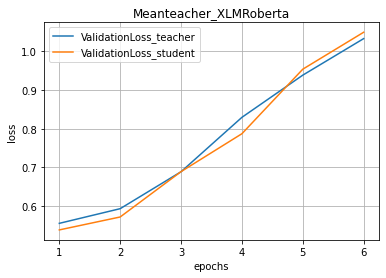

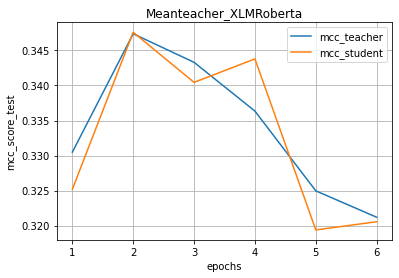

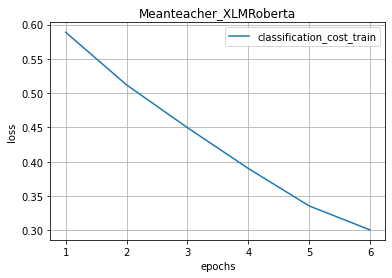

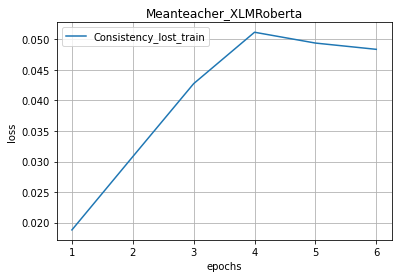

In [58]:
plot_against_epochs(test_cost_teacher,test_cost_student,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student', y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,label1 = 'classification_cost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,label1 = 'Consistency_lost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )

In [25]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [117]:
# writer.add_text('Text','The Labelled data used in this experiment was 3200 and unlabelled used was 6400')


In [25]:
writer = SummaryWriter("runs/MeanTeacherTraining/alpha_0.995_trail1")

In [26]:
metrices = train_MeanTeacher(train_dataloader,val_dataloader,len_labelled_data,len_unlabelled_data,writer, noise_layer=True) # alpha = 0.995 and full data w/o noise and dropout

consistency_cost_lst = get_items(metrices[0])
classification_cost_lst = get_items(metrices[1])
overall_cost_lst = get_items(metrices[2])
f1_class0_student_test = metrices[3]
f1_class1_student_test= metrices[4]
accuracy_student = metrices[5]
mcc_cost_student = metrices[6]
test_cost_student = tensors_to_lst(metrices[7])
f1_class1_teacher_test=metrices[8]
f1_class0_teacher_test = metrices[9]
accuracy_teacher = metrices[10]
mcc_cost_teacher = metrices[11]
test_cost_teacher=tensors_to_lst(metrices[12])

print('Consistency_lost_train :',consistency_cost_lst,'\n',
      'Classificataion_lost_train : ',classification_cost_lst,'\n',
      'Overall_loss_train :',overall_cost_lst,'\n',
      'f1_class0_student_test :',f1_class0_student_test,'\n',
      'f1_class1_student_test :',f1_class1_student_test,'\n',
      'accuracy_student :',accuracy_student,'\n',
      'mcc_cost_student :',mcc_cost_student,'\n',
      'test_cost_student :',test_cost_student,'\n',
      'f1_class0_teacher_test :',f1_class0_teacher_test,'\n',
      'f1_class1_teacher_test :',f1_class1_teacher_test,'\n',
    'accuracy_teacher :', accuracy_teacher,'\n',
      'mcc_cost_teacher',mcc_cost_teacher,'\n',
      'test_cost_teacher',test_cost_teacher)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.

Current epoch is 1 of 30


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /codebuild/output/src811146734/src/torch/csrc/utils/python_arg_parser.cpp:766.)
  del sys.path[0]
 14%|█▎        | 201/1475 [01:45<11:03,  1.92it/s]

train loss :  0.5025104536116123
Consistency Cost : 0.3106546004116535
Classification Cost : 0.6943663051724434


 27%|██▋       | 401/1475 [03:29<09:22,  1.91it/s]

train loss :  0.4890207730792463
Consistency Cost : 0.28870287522673604
Classification Cost : 0.6893386700749398


 41%|████      | 601/1475 [05:15<07:39,  1.90it/s]

train loss :  0.4771548883492748
Consistency Cost : 0.2712601638585329
Classification Cost : 0.6830496123433113


 54%|█████▍    | 801/1475 [06:59<05:51,  1.92it/s]

train loss :  0.4670069411583245
Consistency Cost : 0.2562988097779453
Classification Cost : 0.6777150715887547


 68%|██████▊   | 1001/1475 [08:44<04:09,  1.90it/s]

train loss :  0.45661080449819563
Consistency Cost : 0.2419954103678465
Classification Cost : 0.6712261982560158


 81%|████████▏ | 1201/1475 [10:30<02:27,  1.85it/s]

train loss :  0.4465105325107773
Consistency Cost : 0.22803132900347312
Classification Cost : 0.6649897359808286


 95%|█████████▍| 1401/1475 [12:21<00:41,  1.76it/s]

train loss :  0.43814650370606356
Consistency Cost : 0.21468878998288085
Classification Cost : 0.6616042174824647


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:46<00:00,  8.61it/s]


Overall validation loss: tensor(0.6358, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.290860604926431
Average F1 Validation score for whole sentence class 1 : 0.9249816258806585
Average Accuracy Validation score whole sentence  : 0.8643168848606915
Average mcc Validation score whole sentence : 0.2397608891681719
Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.22      0.29     28264
           1       0.89      0.96      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.59      0.61    223425
weighted avg       0.84      0.86      0.84    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:46<00:00,  8.65it/s]


Overall validation loss: tensor(0.6387, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3121208035593906
Average F1 Validation score for whole sentence class 1 : 0.923916609502222
Average Accuracy Validation score whole sentence  : 0.8629875797247398
Average mcc Validation score whole sentence : 0.2536613618000708
Classification Report :
               precision    recall  f1-score   support

           0       0.43      0.25      0.31     28264
           1       0.90      0.95      0.92    195161

    accuracy                           0.86    223425
   macro avg       0.66      0.60      0.62    223425
weighted avg       0.84      0.86      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 2 of 30


 14%|█▎        | 201/1475 [01:52<11:14,  1.89it/s]

train loss :  0.3672399704158306
Consistency Cost : 0.11252039652317762
Classification Cost : 0.6219595436751842


 27%|██▋       | 401/1475 [03:38<09:26,  1.90it/s]

train loss :  0.3598457070067525
Consistency Cost : 0.10632915968075395
Classification Cost : 0.6133622533082962


 41%|████      | 601/1475 [05:23<07:47,  1.87it/s]

train loss :  0.3538869208469987
Consistency Cost : 0.1038464058438937
Classification Cost : 0.603927434682846


 54%|█████▍    | 801/1475 [07:10<05:53,  1.90it/s]

train loss :  0.35093981817830355
Consistency Cost : 0.09966759092174471
Classification Cost : 0.6022120440751314


 68%|██████▊   | 1001/1475 [08:55<04:10,  1.90it/s]

train loss :  0.3475948148462921
Consistency Cost : 0.09624236826971173
Classification Cost : 0.5989472611248493


 81%|████████▏ | 1201/1475 [10:41<02:27,  1.86it/s]

train loss :  0.34540769323706627
Consistency Cost : 0.09407014817620317
Classification Cost : 0.5967452380557855


 95%|█████████▍| 1401/1475 [12:28<00:38,  1.91it/s]

train loss :  0.3445018702266472
Consistency Cost : 0.09322785319760442
Classification Cost : 0.5957758872423853


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.66it/s]


Overall validation loss: tensor(0.6196, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3283201166712242
Average F1 Validation score for whole sentence class 1 : 0.9268523895316231
Average Accuracy Validation score whole sentence  : 0.8680720599753833
Average mcc Validation score whole sentence : 0.27604954556272837
Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.25      0.33     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.61      0.63    223425
weighted avg       0.84      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.64it/s]


Overall validation loss: tensor(0.6221, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3173213440605774
Average F1 Validation score for whole sentence class 1 : 0.9286932450134705
Average Accuracy Validation score whole sentence  : 0.8708738950430793
Average mcc Validation score whole sentence : 0.2741812019113967
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.24      0.32     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.60      0.62    223425
weighted avg       0.84      0.87      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 3 of 30


 14%|█▎        | 201/1475 [01:46<11:13,  1.89it/s]

train loss :  0.3339571374375373
Consistency Cost : 0.0953959091566503
Classification Cost : 0.5725183662772179


 27%|██▋       | 401/1475 [03:31<09:26,  1.90it/s]

train loss :  0.3287966355634853
Consistency Cost : 0.09823736834339797
Classification Cost : 0.5593559033423662


 41%|████      | 601/1475 [05:17<07:45,  1.88it/s]

train loss :  0.3324700704403222
Consistency Cost : 0.10304750952248772
Classification Cost : 0.5618926331400871


 54%|█████▍    | 801/1475 [07:04<05:56,  1.89it/s]

train loss :  0.33648606860544533
Consistency Cost : 0.10930497882422059
Classification Cost : 0.5636671593040228


 68%|██████▊   | 1001/1475 [08:49<04:08,  1.91it/s]

train loss :  0.337634325126186
Consistency Cost : 0.11192507598921657
Classification Cost : 0.5633435754477978


 81%|████████▏ | 1201/1475 [10:34<02:25,  1.88it/s]

train loss :  0.3384629327260579
Consistency Cost : 0.11370161341192822
Classification Cost : 0.5632242529590925


 95%|█████████▍| 1401/1475 [12:22<00:38,  1.90it/s]

train loss :  0.34114420142024754
Consistency Cost : 0.11643510966162597
Classification Cost : 0.5658532939851284


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(0.7050, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.24781023883357817
Average F1 Validation score for whole sentence class 1 : 0.9325705702190749
Average Accuracy Validation score whole sentence  : 0.8762358733355712
Average mcc Validation score whole sentence : 0.2449574784990714
Classification Report :
               precision    recall  f1-score   support

           0       0.54      0.16      0.25     28264
           1       0.89      0.98      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.57      0.59    223425
weighted avg       0.84      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.54it/s]


Overall validation loss: tensor(0.6685, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3003001500750375
Average F1 Validation score for whole sentence class 1 : 0.9312458524835944
Average Accuracy Validation score whole sentence  : 0.8747946738279064
Average mcc Validation score whole sentence : 0.27307552573915833
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.21      0.30     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.59      0.62    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 4 of 30


 14%|█▎        | 201/1475 [01:45<11:11,  1.90it/s]

train loss :  0.35143137944862246
Consistency Cost : 0.1541578551568091
Classification Cost : 0.5487049043923616


 27%|██▋       | 401/1475 [03:31<09:24,  1.90it/s]

train loss :  0.35259619165677575
Consistency Cost : 0.15365509937517344
Classification Cost : 0.5515372837707401


 41%|████      | 601/1475 [05:16<07:41,  1.89it/s]

train loss :  0.35493540024695297
Consistency Cost : 0.15639989376068114
Classification Cost : 0.5534709065655867


 54%|█████▍    | 801/1475 [07:03<06:09,  1.83it/s]

train loss :  0.3606833536433987
Consistency Cost : 0.16108365398366004
Classification Cost : 0.5602830533217639


 68%|██████▊   | 1001/1475 [08:49<04:07,  1.92it/s]

train loss :  0.36266911874338986
Consistency Cost : 0.16142928794026376
Classification Cost : 0.5639089493826032


 81%|████████▏ | 1201/1475 [10:33<02:23,  1.91it/s]

train loss :  0.3655794339999556
Consistency Cost : 0.16532833578065037
Classification Cost : 0.5658305321571727


 95%|█████████▍| 1401/1475 [12:18<00:39,  1.90it/s]

train loss :  0.36720461915114094
Consistency Cost : 0.16801240856094019
Classification Cost : 0.566396829970181


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.62it/s]


Overall validation loss: tensor(0.7442, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3152810304449649
Average F1 Validation score for whole sentence class 1 : 0.9308428070901645
Average Accuracy Validation score whole sentence  : 0.8743739509902652
Average mcc Validation score whole sentence : 0.28184995797335977
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.23      0.32     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.60      0.62    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.59it/s]


Overall validation loss: tensor(0.7921, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.29359426094451063
Average F1 Validation score for whole sentence class 1 : 0.9315981060429405
Average Accuracy Validation score whole sentence  : 0.8752735817388385
Average mcc Validation score whole sentence : 0.270190546534738
Classification Report :
               precision    recall  f1-score   support

           0       0.52      0.20      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.59      0.61    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 5 of 30


 14%|█▎        | 201/1475 [01:46<11:20,  1.87it/s]

train loss :  0.37311700578778983
Consistency Cost : 0.18971503723412753
Classification Cost : 0.556518976315856


 27%|██▋       | 401/1475 [03:33<09:24,  1.90it/s]

train loss :  0.37145598406903446
Consistency Cost : 0.1968692796677351
Classification Cost : 0.5460426895599813


 41%|████      | 601/1475 [05:18<07:40,  1.90it/s]

train loss :  0.37548765456303956
Consistency Cost : 0.19779800108323495
Classification Cost : 0.5531773082042734


 54%|█████▍    | 801/1475 [07:02<05:51,  1.92it/s]

train loss :  0.37880563861690464
Consistency Cost : 0.20442205348052084
Classification Cost : 0.5531892239488662


 68%|██████▊   | 1001/1475 [08:47<04:07,  1.91it/s]

train loss :  0.3783950314670801
Consistency Cost : 0.20581813688576223
Classification Cost : 0.5509719264283777


 81%|████████▏ | 1201/1475 [10:31<02:24,  1.90it/s]

train loss :  0.37733023478028677
Consistency Cost : 0.20705145741502443
Classification Cost : 0.5476090122262637


 95%|█████████▍| 1401/1475 [12:17<00:39,  1.86it/s]

train loss :  0.37941576568675894
Consistency Cost : 0.20983433128999812
Classification Cost : 0.5489972001500427


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.55it/s]


Overall validation loss: tensor(0.7906, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.30663424459018
Average F1 Validation score for whole sentence class 1 : 0.9304938973794558
Average Accuracy Validation score whole sentence  : 0.8736533512364328
Average mcc Validation score whole sentence : 0.27396015551957903
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.22      0.31     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.59      0.62    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(0.9041, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.290001789503285
Average F1 Validation score for whole sentence class 1 : 0.9318843458832128
Average Accuracy Validation score whole sentence  : 0.8756943045764798
Average mcc Validation score whole sentence : 0.26925512586947326
Classification Report :
               precision    recall  f1-score   support

           0       0.52      0.20      0.29     28264
           1       0.89      0.97      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.59      0.61    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 6 of 30


 14%|█▎        | 201/1475 [01:45<11:12,  1.89it/s]

train loss :  0.3586377448961139
Consistency Cost : 0.21262030586600303
Classification Cost : 0.5046551872976124


 27%|██▋       | 401/1475 [03:32<09:32,  1.87it/s]

train loss :  0.3627839094772935
Consistency Cost : 0.21700333550572395
Classification Cost : 0.5085644856281578


 41%|████      | 601/1475 [05:17<07:36,  1.91it/s]

train loss :  0.36712858252227304
Consistency Cost : 0.22483313351869583
Classification Cost : 0.5094240325937669


 54%|█████▍    | 801/1475 [07:03<05:56,  1.89it/s]

train loss :  0.3726095174346119
Consistency Cost : 0.2314715474564582
Classification Cost : 0.5137474881950765


 68%|██████▊   | 1001/1475 [08:50<04:09,  1.90it/s]

train loss :  0.3715592807121575
Consistency Cost : 0.2340088608339429
Classification Cost : 0.5091097018644214


 81%|████████▏ | 1201/1475 [10:35<02:24,  1.89it/s]

train loss :  0.3721924633656939
Consistency Cost : 0.23138724737490216
Classification Cost : 0.5129976800022026


 95%|█████████▍| 1401/1475 [12:21<00:39,  1.87it/s]

train loss :  0.3701197923240917
Consistency Cost : 0.23208414324160134
Classification Cost : 0.5081554420292378


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.31it/s]


Overall validation loss: tensor(0.9337, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3272848185445563
Average F1 Validation score for whole sentence class 1 : 0.9300203090333197
Average Accuracy Validation score whole sentence  : 0.8732281526239231
Average mcc Validation score whole sentence : 0.287055143069318
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.24      0.33     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.60      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.59it/s]


Overall validation loss: tensor(0.9220, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.33023266822883385
Average F1 Validation score for whole sentence class 1 : 0.930061962278887
Average Accuracy Validation score whole sentence  : 0.8733489985453732
Average mcc Validation score whole sentence : 0.2894226830025728
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.25      0.33     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 7 of 30


 14%|█▎        | 201/1475 [01:45<11:08,  1.91it/s]

train loss :  0.3529306602291763
Consistency Cost : 0.22869948968291282
Classification Cost : 0.4771618311293423


 27%|██▋       | 401/1475 [03:31<09:40,  1.85it/s]

train loss :  0.349608460245654
Consistency Cost : 0.2380722675472498
Classification Cost : 0.46114465227350593


 41%|████      | 601/1475 [05:18<07:41,  1.89it/s]

train loss :  0.3431341157356898
Consistency Cost : 0.23604031798740227
Classification Cost : 0.4502279127854854


 54%|█████▍    | 801/1475 [07:03<05:56,  1.89it/s]

train loss :  0.345345274633728
Consistency Cost : 0.23663394182920455
Classification Cost : 0.45405660638352857


 68%|██████▊   | 1001/1475 [08:51<04:18,  1.83it/s]

train loss :  0.34532106867805124
Consistency Cost : 0.23827335944771766
Classification Cost : 0.4523687770273536


 81%|████████▏ | 1201/1475 [10:36<02:24,  1.90it/s]

train loss :  0.34672998896489543
Consistency Cost : 0.23901173893983166
Classification Cost : 0.4544482381719475


 95%|█████████▍| 1401/1475 [12:21<00:39,  1.89it/s]

train loss :  0.3487652758029955
Consistency Cost : 0.239042580537498
Classification Cost : 0.4584879702422768


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.32it/s]


Overall validation loss: tensor(0.9819, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.32424649644845466
Average F1 Validation score for whole sentence class 1 : 0.9304996816214108
Average Accuracy Validation score whole sentence  : 0.873962179702361
Average mcc Validation score whole sentence : 0.2868443607765691
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.24      0.32     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.60      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.42it/s]


Overall validation loss: tensor(0.9853, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3231566820276498
Average F1 Validation score for whole sentence class 1 : 0.9304023337430217
Average Accuracy Validation score whole sentence  : 0.87378314870762
Average mcc Validation score whole sentence : 0.28562094783281355
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.24      0.32     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.60      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 8 of 30


 14%|█▎        | 201/1475 [01:45<11:10,  1.90it/s]

train loss :  0.3252021073363721
Consistency Cost : 0.22556866716593504
Classification Cost : 0.4248355467058718


 27%|██▋       | 401/1475 [03:32<09:36,  1.86it/s]

train loss :  0.3228544553555548
Consistency Cost : 0.23250379312783478
Classification Cost : 0.4132051160186529


 41%|████      | 601/1475 [05:19<07:40,  1.90it/s]

train loss :  0.3278201361310979
Consistency Cost : 0.23730517896513145
Classification Cost : 0.4183350924185167


 54%|█████▍    | 801/1475 [07:04<05:55,  1.90it/s]

train loss :  0.328895665416494
Consistency Cost : 0.2399362599523738
Classification Cost : 0.41785507046617565


 68%|██████▊   | 1001/1475 [08:50<04:14,  1.86it/s]

train loss :  0.32965202677622435
Consistency Cost : 0.2424016486145556
Classification Cost : 0.4169024045933038


 81%|████████▏ | 1201/1475 [10:37<02:24,  1.90it/s]

train loss :  0.32806985429798563
Consistency Cost : 0.24307931503591437
Classification Cost : 0.4130603931456183


 95%|█████████▍| 1401/1475 [12:22<00:39,  1.90it/s]

train loss :  0.3277989348902234
Consistency Cost : 0.24476265393463628
Classification Cost : 0.4108352153641837


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.44it/s]


Overall validation loss: tensor(1.0938, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3107545900700032
Average F1 Validation score for whole sentence class 1 : 0.9319734748923677
Average Accuracy Validation score whole sentence  : 0.8761687367125434
Average mcc Validation score whole sentence : 0.2841427500634839
Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.22      0.31     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.88    223425
   macro avg       0.71      0.60      0.62    223425
weighted avg       0.85      0.88      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:43<00:00,  9.29it/s]


Overall validation loss: tensor(1.0318, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34237152851139746
Average F1 Validation score for whole sentence class 1 : 0.9307042866719605
Average Accuracy Validation score whole sentence  : 0.874620118608034
Average mcc Validation score whole sentence : 0.3010709547094687
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 9 of 30


 14%|█▎        | 201/1475 [01:45<11:07,  1.91it/s]

train loss :  0.3180319951754063
Consistency Cost : 0.24022820949554444
Classification Cost : 0.39583577912300827


 27%|██▋       | 401/1475 [03:30<09:28,  1.89it/s]

train loss :  0.3133433166099712
Consistency Cost : 0.2410858098603785
Classification Cost : 0.385600822577253


 41%|████      | 601/1475 [05:18<07:40,  1.90it/s]

train loss :  0.31410671850976846
Consistency Cost : 0.24653697690616053
Classification Cost : 0.38167645905011643


 54%|█████▍    | 801/1475 [07:03<05:55,  1.89it/s]

train loss :  0.3142280008853413
Consistency Cost : 0.2470931765716523
Classification Cost : 0.3813628245878499


 68%|██████▊   | 1001/1475 [08:49<04:13,  1.87it/s]

train loss :  0.31658077171631155
Consistency Cost : 0.2502323264181614
Classification Cost : 0.3829292164957151


 81%|████████▏ | 1201/1475 [10:37<02:24,  1.90it/s]

train loss :  0.31749299050774427
Consistency Cost : 0.251907232919087
Classification Cost : 0.38307874775414047


 95%|█████████▍| 1401/1475 [12:22<00:38,  1.90it/s]

train loss :  0.31847055433451066
Consistency Cost : 0.2531689244934491
Classification Cost : 0.383772183733194


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.46it/s]


Overall validation loss: tensor(1.0902, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3344818572820379
Average F1 Validation score for whole sentence class 1 : 0.9308071063105441
Average Accuracy Validation score whole sentence  : 0.8746469732572452
Average mcc Validation score whole sentence : 0.2956798324358193
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.25      0.33     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(1.0674, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3427386472191803
Average F1 Validation score for whole sentence class 1 : 0.9301638151070355
Average Accuracy Validation score whole sentence  : 0.8737428667338033
Average mcc Validation score whole sentence : 0.2991855098497766
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 10 of 30


 14%|█▎        | 201/1475 [01:45<11:04,  1.92it/s]

train loss :  0.28873913644813
Consistency Cost : 0.2312275341153145
Classification Cost : 0.3462507376959547


 27%|██▋       | 401/1475 [03:30<09:26,  1.89it/s]

train loss :  0.2952999569196254
Consistency Cost : 0.2334590943902731
Classification Cost : 0.3571408186969347


 41%|████      | 601/1475 [05:17<07:58,  1.83it/s]

train loss :  0.2904173221811652
Consistency Cost : 0.23281279335419336
Classification Cost : 0.34802185057196766


 54%|█████▍    | 801/1475 [07:02<05:54,  1.90it/s]

train loss :  0.29678727574646474
Consistency Cost : 0.23816512694582342
Classification Cost : 0.35540942412917503


 68%|██████▊   | 1001/1475 [08:48<04:10,  1.89it/s]

train loss :  0.2988080152440816
Consistency Cost : 0.24470153965801
Classification Cost : 0.35291449050512164


 81%|████████▏ | 1201/1475 [10:35<02:26,  1.87it/s]

train loss :  0.3008064516028389
Consistency Cost : 0.24564373238633078
Classification Cost : 0.3559691706711116


 95%|█████████▍| 1401/1475 [12:20<00:38,  1.91it/s]

train loss :  0.30103337253443896
Consistency Cost : 0.2451085052878729
Classification Cost : 0.35695823943242433


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


Overall validation loss: tensor(1.2094, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3387628239583089
Average F1 Validation score for whole sentence class 1 : 0.9299730979881651
Average Accuracy Validation score whole sentence  : 0.8733579500951102
Average mcc Validation score whole sentence : 0.2954497285000922
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.48it/s]


Overall validation loss: tensor(1.1524, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.33758173031365485
Average F1 Validation score for whole sentence class 1 : 0.9308962578897682
Average Accuracy Validation score whole sentence  : 0.8748483831263287
Average mcc Validation score whole sentence : 0.29833361077287085
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.25      0.34     28264
           1       0.90      0.97      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 11 of 30


 14%|█▎        | 201/1475 [01:47<11:12,  1.89it/s]

train loss :  0.2908164101280272
Consistency Cost : 0.25244825465604664
Classification Cost : 0.329184565320611


 27%|██▋       | 401/1475 [03:33<09:27,  1.89it/s]

train loss :  0.28413172864355146
Consistency Cost : 0.24527763126417995
Classification Cost : 0.3229858264583163


 41%|████      | 601/1475 [05:20<07:51,  1.86it/s]

train loss :  0.28378932519505423
Consistency Cost : 0.24552909296626846
Classification Cost : 0.32204955790036666


 54%|█████▍    | 801/1475 [07:06<05:55,  1.89it/s]

train loss :  0.289968003295362
Consistency Cost : 0.25082471877336504
Classification Cost : 0.3291112882061861


 68%|██████▊   | 1001/1475 [08:52<04:10,  1.89it/s]

train loss :  0.2917921616695821
Consistency Cost : 0.25223174701817336
Classification Cost : 0.3313525769133121


 81%|████████▏ | 1201/1475 [10:39<02:29,  1.83it/s]

train loss :  0.2893847924874475
Consistency Cost : 0.24962087835650892
Classification Cost : 0.329148706777487


 95%|█████████▍| 1401/1475 [12:25<00:38,  1.90it/s]

train loss :  0.28843336254491336
Consistency Cost : 0.24969538210359002
Classification Cost : 0.3271713432882513


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Overall validation loss: tensor(1.1446, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34682505102391814
Average F1 Validation score for whole sentence class 1 : 0.9293651718690715
Average Accuracy Validation score whole sentence  : 0.8725165044198276
Average mcc Validation score whole sentence : 0.2992707331427194
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(1.2122, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3425759046166644
Average F1 Validation score for whole sentence class 1 : 0.929499568850168
Average Accuracy Validation score whole sentence  : 0.8726552534407519
Average mcc Validation score whole sentence : 0.2965182481485629
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 12 of 30


 14%|█▎        | 201/1475 [01:45<11:09,  1.90it/s]

train loss :  0.2566366421338171
Consistency Cost : 0.21852057450450957
Classification Cost : 0.29475271014496685


 27%|██▋       | 401/1475 [03:30<09:26,  1.90it/s]

train loss :  0.2684510170482099
Consistency Cost : 0.2345446539670229
Classification Cost : 0.302357379689347


 41%|████      | 601/1475 [05:17<07:50,  1.86it/s]

train loss :  0.269925993407766
Consistency Cost : 0.23674961456408103
Classification Cost : 0.3031023716259127


 54%|█████▍    | 801/1475 [07:06<05:58,  1.88it/s]

train loss :  0.27334698670078067
Consistency Cost : 0.24219440965680405
Classification Cost : 0.3044995631754864


 68%|██████▊   | 1001/1475 [08:51<04:10,  1.89it/s]

train loss :  0.2739690411072224
Consistency Cost : 0.24301919729076327
Classification Cost : 0.304918884312734


 81%|████████▏ | 1201/1475 [10:38<02:27,  1.85it/s]

train loss :  0.2749470339094599
Consistency Cost : 0.24302197493457545
Classification Cost : 0.3068720925001738


 95%|█████████▍| 1401/1475 [12:26<00:39,  1.89it/s]

train loss :  0.2755213819696967
Consistency Cost : 0.24398071020176368
Classification Cost : 0.30706205344559356


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.59it/s]


Overall validation loss: tensor(1.2935, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3474659096197701
Average F1 Validation score for whole sentence class 1 : 0.9305677980370213
Average Accuracy Validation score whole sentence  : 0.8744903211368468
Average mcc Validation score whole sentence : 0.3043136677998224
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.26      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.50it/s]


Overall validation loss: tensor(1.2391, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3412437857611856
Average F1 Validation score for whole sentence class 1 : 0.9305007842535736
Average Accuracy Validation score whole sentence  : 0.8742665323934206
Average mcc Validation score whole sentence : 0.29940821140312995
Classification Report :
               precision    recall  f1-score   support

           0       0.51      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 13 of 30


 14%|█▎        | 201/1475 [01:47<11:39,  1.82it/s]

train loss :  0.25660047570243477
Consistency Cost : 0.225664099175483
Classification Cost : 0.2875368516659364


 27%|██▋       | 401/1475 [03:33<09:23,  1.90it/s]

train loss :  0.2605084021855146
Consistency Cost : 0.23024252518545837
Classification Cost : 0.2907742790435441


 41%|████      | 601/1475 [05:18<07:44,  1.88it/s]

train loss :  0.2637244328514983
Consistency Cost : 0.23609604981727897
Classification Cost : 0.2913528159369404


 54%|█████▍    | 801/1475 [07:06<06:01,  1.87it/s]

train loss :  0.2674842741945758
Consistency Cost : 0.2395062035904266
Classification Cost : 0.29546234515844844


 68%|██████▊   | 1001/1475 [08:51<04:09,  1.90it/s]

train loss :  0.26638807586021723
Consistency Cost : 0.24075197486765681
Classification Cost : 0.29202417710237205


 81%|████████▏ | 1201/1475 [10:36<02:25,  1.88it/s]

train loss :  0.26743193477702637
Consistency Cost : 0.24006592750394096
Classification Cost : 0.29479794240013385


 95%|█████████▍| 1401/1475 [12:24<00:38,  1.90it/s]

train loss :  0.2689788076933473
Consistency Cost : 0.24218500377211188
Classification Cost : 0.29577261166447505


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.61it/s]


Overall validation loss: tensor(1.1958, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3610531632227321
Average F1 Validation score for whole sentence class 1 : 0.9274951346960337
Average Accuracy Validation score whole sentence  : 0.8697683786505539
Average mcc Validation score whole sentence : 0.30425812259928153
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.29      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Overall validation loss: tensor(1.2962, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34178013405890184
Average F1 Validation score for whole sentence class 1 : 0.9302457967542256
Average Accuracy Validation score whole sentence  : 0.8738592368803849
Average mcc Validation score whole sentence : 0.29878947688069096
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 14 of 30


 14%|█▎        | 201/1475 [01:46<11:23,  1.86it/s]

train loss :  0.2486448109196499
Consistency Cost : 0.23335841096937657
Classification Cost : 0.2639312096312642


 27%|██▋       | 401/1475 [03:33<09:21,  1.91it/s]

train loss :  0.2544629207649268
Consistency Cost : 0.23824813317041843
Classification Cost : 0.27067770704743455


 41%|████      | 601/1475 [05:17<07:37,  1.91it/s]

train loss :  0.26089114845575145
Consistency Cost : 0.24357318420273563
Classification Cost : 0.2782091110649829


 54%|█████▍    | 801/1475 [07:02<05:52,  1.91it/s]

train loss :  0.2587358420633245
Consistency Cost : 0.23986216951394454
Classification Cost : 0.2776095136767253


 68%|██████▊   | 1001/1475 [08:47<04:07,  1.92it/s]

train loss :  0.2601814712202176
Consistency Cost : 0.24085678231902422
Classification Cost : 0.27950615927763284


 81%|████████▏ | 1201/1475 [10:31<02:23,  1.91it/s]

train loss :  0.2604019091658605
Consistency Cost : 0.24241125818341971
Classification Cost : 0.2783925595499265


 95%|█████████▍| 1401/1475 [12:16<00:38,  1.91it/s]

train loss :  0.26193324287887665
Consistency Cost : 0.24682663018416082
Classification Cost : 0.27703985518576313


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.61it/s]


Overall validation loss: tensor(1.3635, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3410060868956832
Average F1 Validation score for whole sentence class 1 : 0.9300519096667831
Average Accuracy Validation score whole sentence  : 0.8735280295401141
Average mcc Validation score whole sentence : 0.2974454578717086
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.59it/s]


Overall validation loss: tensor(1.3116, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34412533845548593
Average F1 Validation score for whole sentence class 1 : 0.9297862694140061
Average Accuracy Validation score whole sentence  : 0.8731520644511581
Average mcc Validation score whole sentence : 0.29877666817601417
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 15 of 30


 14%|█▎        | 201/1475 [01:46<11:20,  1.87it/s]

train loss :  0.26269678803160784
Consistency Cost : 0.24636016922071577
Classification Cost : 0.2790334047097713


 27%|██▋       | 401/1475 [03:34<09:27,  1.89it/s]

train loss :  0.2604938908666372
Consistency Cost : 0.24312656142748892
Classification Cost : 0.2778612201253418


 41%|████      | 601/1475 [05:19<07:41,  1.89it/s]

train loss :  0.2559128706716001
Consistency Cost : 0.2401953671934704
Classification Cost : 0.2716303736840685


 54%|█████▍    | 801/1475 [07:05<06:01,  1.87it/s]

train loss :  0.25221117807086557
Consistency Cost : 0.23482681022956967
Classification Cost : 0.2695955455041258


 68%|██████▊   | 1001/1475 [08:52<04:09,  1.90it/s]

train loss :  0.2514736019270495
Consistency Cost : 0.23526269257999957
Classification Cost : 0.26768451042007657


 81%|████████▏ | 1201/1475 [10:37<02:23,  1.91it/s]

train loss :  0.2518339464487508
Consistency Cost : 0.23322519360731045
Classification Cost : 0.27044269850205943


 95%|█████████▍| 1401/1475 [12:22<00:38,  1.92it/s]

train loss :  0.24995158662088215
Consistency Cost : 0.23269346707367472
Classification Cost : 0.2672097053285688


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Overall validation loss: tensor(1.2771, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35815888352120234
Average F1 Validation score for whole sentence class 1 : 0.92863643823762
Average Accuracy Validation score whole sentence  : 0.871554212823095
Average mcc Validation score whole sentence : 0.3055501843565844
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.28      0.36     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.67it/s]


Overall validation loss: tensor(1.3716, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35003647638154295
Average F1 Validation score for whole sentence class 1 : 0.929253125418749
Average Accuracy Validation score whole sentence  : 0.8723956584983775
Average mcc Validation score whole sentence : 0.3013369461253151
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 16 of 30


 14%|█▎        | 201/1475 [01:45<11:11,  1.90it/s]

train loss :  0.24095461030490697
Consistency Cost : 0.23773638924583793
Classification Cost : 0.24417283348971977


 27%|██▋       | 401/1475 [03:32<09:44,  1.84it/s]

train loss :  0.23733609288465232
Consistency Cost : 0.22558369724079966
Classification Cost : 0.24908849016646856


 41%|████      | 601/1475 [05:18<07:39,  1.90it/s]

train loss :  0.23557457474681237
Consistency Cost : 0.22575496102993686
Classification Cost : 0.24539418941441302


 54%|█████▍    | 801/1475 [07:03<05:59,  1.88it/s]

train loss :  0.2371924892172683
Consistency Cost : 0.22848102196818218
Classification Cost : 0.24590395718289074


 68%|██████▊   | 1001/1475 [08:51<04:12,  1.88it/s]

train loss :  0.23704108793847262
Consistency Cost : 0.22794028772041203
Classification Cost : 0.24614188863849268


 81%|████████▏ | 1201/1475 [10:36<02:24,  1.90it/s]

train loss :  0.23689460359436149
Consistency Cost : 0.2280117022556563
Classification Cost : 0.24577750528852144


 95%|█████████▍| 1401/1475 [12:22<00:39,  1.87it/s]

train loss :  0.23889880423367554
Consistency Cost : 0.22957452053603317
Classification Cost : 0.24822308833777373


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:43<00:00,  9.22it/s]


Overall validation loss: tensor(1.4249, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3426677175576058
Average F1 Validation score for whole sentence class 1 : 0.9297618103994928
Average Accuracy Validation score whole sentence  : 0.8730849278281303
Average mcc Validation score whole sentence : 0.2975787525335241
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.52it/s]


Overall validation loss: tensor(1.4199, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3497772265858252
Average F1 Validation score for whole sentence class 1 : 0.9298005494559989
Average Accuracy Validation score whole sentence  : 0.8732818619223454
Average mcc Validation score whole sentence : 0.3031258214213537
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 17 of 30


 14%|█▎        | 201/1475 [01:45<11:12,  1.90it/s]

train loss :  0.23064947652164847
Consistency Cost : 0.22278825565241278
Classification Cost : 0.23851069666212424


 27%|██▋       | 401/1475 [03:32<09:38,  1.86it/s]

train loss :  0.22909549586940556
Consistency Cost : 0.21796251474879683
Classification Cost : 0.24022847666987218


 41%|████      | 601/1475 [05:18<07:39,  1.90it/s]

train loss :  0.23019726464835305
Consistency Cost : 0.2185114824709793
Classification Cost : 0.24188304582998776


 54%|█████▍    | 801/1475 [07:03<05:55,  1.90it/s]

train loss :  0.22931927116005682
Consistency Cost : 0.21961651335470378
Classification Cost : 0.23902202812663745


 68%|██████▊   | 1001/1475 [08:50<04:19,  1.83it/s]

train loss :  0.22909270343836396
Consistency Cost : 0.2195689010042697
Classification Cost : 0.23861650518514216


 81%|████████▏ | 1201/1475 [10:36<02:23,  1.91it/s]

train loss :  0.22783339652776097
Consistency Cost : 0.21784532805439086
Classification Cost : 0.23782146438296572


 95%|█████████▍| 1401/1475 [12:22<00:39,  1.88it/s]

train loss :  0.23235392133838365
Consistency Cost : 0.22206289147825115
Classification Cost : 0.2426449504910436


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.31it/s]


Overall validation loss: tensor(1.4873, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3346095834783618
Average F1 Validation score for whole sentence class 1 : 0.9289792076878305
Average Accuracy Validation score whole sentence  : 0.8716571556450711
Average mcc Validation score whole sentence : 0.2884838106405731
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.26      0.33     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.61      0.63    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.30it/s]


Overall validation loss: tensor(1.4199, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3427485808459989
Average F1 Validation score for whole sentence class 1 : 0.9287780098322759
Average Accuracy Validation score whole sentence  : 0.8714826004251987
Average mcc Validation score whole sentence : 0.294014422929072
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.26      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.61      0.64    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 18 of 30


 14%|█▎        | 201/1475 [01:45<11:11,  1.90it/s]

train loss :  0.21489203436300158
Consistency Cost : 0.20680913714691995
Classification Cost : 0.22297493071993812


 27%|██▋       | 401/1475 [03:31<09:33,  1.87it/s]

train loss :  0.21601593928644433
Consistency Cost : 0.2114217837760225
Classification Cost : 0.22061009391909464


 41%|████      | 601/1475 [05:18<07:40,  1.90it/s]

train loss :  0.2191763881749163
Consistency Cost : 0.21351417591795324
Classification Cost : 0.22483859977840134


 54%|█████▍    | 801/1475 [07:04<05:55,  1.90it/s]

train loss :  0.2233070856879931
Consistency Cost : 0.21488455935847015
Classification Cost : 0.23172961143776774


 68%|██████▊   | 1001/1475 [08:50<04:14,  1.86it/s]

train loss :  0.22691242767497896
Consistency Cost : 0.21958727457001806
Classification Cost : 0.23423758071567863


 81%|████████▏ | 1201/1475 [10:37<02:24,  1.90it/s]

train loss :  0.22765576131020984
Consistency Cost : 0.21954631742245206
Classification Cost : 0.23576520520611666


 95%|█████████▍| 1401/1475 [12:22<00:39,  1.90it/s]

train loss :  0.22735519047893052
Consistency Cost : 0.2187563160514193
Classification Cost : 0.2359540649144245


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.42it/s]


Overall validation loss: tensor(1.5630, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.34496364095152887
Average F1 Validation score for whole sentence class 1 : 0.9291890779329312
Average Accuracy Validation score whole sentence  : 0.872194248629294
Average mcc Validation score whole sentence : 0.2972012942741736
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


Overall validation loss: tensor(1.4932, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3511841359773371
Average F1 Validation score for whole sentence class 1 : 0.9289117884412441
Average Accuracy Validation score whole sentence  : 0.8718630412890231
Average mcc Validation score whole sentence : 0.3010265932674711
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 19 of 30


 14%|█▎        | 201/1475 [01:46<11:07,  1.91it/s]

train loss :  0.21342454767785968
Consistency Cost : 0.20097556210123002
Classification Cost : 0.22587353451643138


 27%|██▋       | 401/1475 [03:31<09:25,  1.90it/s]

train loss :  0.21908893288578837
Consistency Cost : 0.2071806446323171
Classification Cost : 0.23099722140817902


 41%|████      | 601/1475 [05:16<07:40,  1.90it/s]

train loss :  0.21526955887054403
Consistency Cost : 0.20764091331201295
Classification Cost : 0.2228982048854232


 54%|█████▍    | 801/1475 [07:01<05:54,  1.90it/s]

train loss :  0.21659210326964967
Consistency Cost : 0.20687286442844197
Classification Cost : 0.22631134235183709


 68%|██████▊   | 1001/1475 [08:47<04:12,  1.87it/s]

train loss :  0.21569916453026236
Consistency Cost : 0.20724572365544736
Classification Cost : 0.22415260597178713


 81%|████████▏ | 1201/1475 [10:35<02:24,  1.89it/s]

train loss :  0.21677133663712692
Consistency Cost : 0.20749307349479446
Classification Cost : 0.22604960027810497


 95%|█████████▍| 1401/1475 [12:20<00:39,  1.90it/s]

train loss :  0.21781474712304771
Consistency Cost : 0.20866975939566534
Classification Cost : 0.226959735374299


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Overall validation loss: tensor(1.4631, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.35734281270828705
Average F1 Validation score for whole sentence class 1 : 0.9280161258212223
Average Accuracy Validation score whole sentence  : 0.8705337361530715
Average mcc Validation score whole sentence : 0.3028995738841587
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.28      0.36     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Overall validation loss: tensor(1.4715, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3602939553770441
Average F1 Validation score for whole sentence class 1 : 0.92780989049577
Average Accuracy Validation score whole sentence  : 0.8702607138860915
Average mcc Validation score whole sentence : 0.3046088001273259
Classification Report :
               precision    recall  f1-score   support

           0       0.48      0.29      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 20 of 30


 14%|█▎        | 201/1475 [01:45<11:08,  1.91it/s]

train loss :  0.2034899480547756
Consistency Cost : 0.19909534566104412
Classification Cost : 0.2078845512983389


 27%|██▋       | 401/1475 [03:31<09:26,  1.90it/s]

train loss :  0.20533050380414353
Consistency Cost : 0.19830915802158416
Classification Cost : 0.2123518498346675


 41%|████      | 601/1475 [05:17<07:56,  1.83it/s]

train loss :  0.20883548367302865
Consistency Cost : 0.2009645330750694
Classification Cost : 0.2167064341258568


 54%|█████▍    | 801/1475 [07:04<05:54,  1.90it/s]

train loss :  0.20884884554194286
Consistency Cost : 0.20236396607477217
Classification Cost : 0.21533372513193172


 68%|██████▊   | 1001/1475 [08:49<04:11,  1.88it/s]

train loss :  0.21052757356408983
Consistency Cost : 0.20358138931915165
Classification Cost : 0.21747375761577858


 81%|████████▏ | 1201/1475 [10:37<02:30,  1.82it/s]

train loss :  0.21261855194888388
Consistency Cost : 0.20705928391621758
Classification Cost : 0.2181778198189568


 95%|█████████▍| 1401/1475 [12:23<00:38,  1.90it/s]

train loss :  0.2118333890501942
Consistency Cost : 0.20622367360096958
Classification Cost : 0.21744310445152223


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:42<00:00,  9.52it/s]


Overall validation loss: tensor(1.4070, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3619358861344628
Average F1 Validation score for whole sentence class 1 : 0.9258703248996476
Average Accuracy Validation score whole sentence  : 0.8671724292268099
Average mcc Validation score whole sentence : 0.3003348260475882
Classification Report :
               precision    recall  f1-score   support

           0       0.46      0.30      0.36     28264
           1       0.90      0.95      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.68      0.62      0.64    223425
weighted avg       0.85      0.87      0.85    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:42<00:00,  9.45it/s]


Overall validation loss: tensor(1.5432, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3508351603643514
Average F1 Validation score for whole sentence class 1 : 0.9286624425308055
Average Accuracy Validation score whole sentence  : 0.871451270001119
Average mcc Validation score whole sentence : 0.2998976185785098
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 21 of 30


 14%|█▎        | 201/1475 [01:48<11:11,  1.90it/s]

train loss :  0.196059250109829
Consistency Cost : 0.19884139937348663
Classification Cost : 0.19327709916280583


 27%|██▋       | 401/1475 [03:33<09:26,  1.90it/s]

train loss :  0.20600658390903845
Consistency Cost : 0.2006365888984874
Classification Cost : 0.21137657840619795


 41%|████      | 601/1475 [05:19<07:42,  1.89it/s]

train loss :  0.20318561955665548
Consistency Cost : 0.19782014354442556
Classification Cost : 0.2085510954229782


 54%|█████▍    | 801/1475 [07:03<05:53,  1.90it/s]

train loss :  0.2053189137915615
Consistency Cost : 0.20157276483252645
Classification Cost : 0.20906506271974648


 68%|██████▊   | 1001/1475 [08:49<04:09,  1.90it/s]

train loss :  0.20222822454944253
Consistency Cost : 0.1965799067746848
Classification Cost : 0.20787654244992881


 81%|████████▏ | 1201/1475 [10:35<02:28,  1.85it/s]

train loss :  0.20347257484837125
Consistency Cost : 0.19689110062395532
Classification Cost : 0.21005404903863867


 95%|█████████▍| 1401/1475 [12:22<00:38,  1.91it/s]

train loss :  0.2042475193539368
Consistency Cost : 0.19744392599910499
Classification Cost : 0.21105111271492205


  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for student -------------


100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Overall validation loss: tensor(1.6681, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3366359879789632
Average F1 Validation score for whole sentence class 1 : 0.9301089898035413
Average Accuracy Validation score whole sentence  : 0.8735414568647197
Average mcc Validation score whole sentence : 0.2943944870257376
Classification Report :
               precision    recall  f1-score   support

           0       0.50      0.25      0.34     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.70      0.61      0.63    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/400 [00:00<?, ?it/s]

---------Running validation for teacher -------------


100%|██████████| 400/400 [00:41<00:00,  9.54it/s]


Overall validation loss: tensor(1.5767, device='cuda:0')
Average F1 Validation score for whole sentence class 0 : 0.3511229608206426
Average F1 Validation score for whole sentence class 1 : 0.9286672363087195
Average Accuracy Validation score whole sentence  : 0.8714646973257245
Average mcc Validation score whole sentence : 0.3001387403406461
Classification Report :
               precision    recall  f1-score   support

           0       0.49      0.27      0.35     28264
           1       0.90      0.96      0.93    195161

    accuracy                           0.87    223425
   macro avg       0.69      0.62      0.64    223425
weighted avg       0.85      0.87      0.86    223425



  0%|          | 0/1475 [00:00<?, ?it/s]

Current epoch is 22 of 30


 11%|█         | 165/1475 [01:27<11:37,  1.88it/s]


KeyboardInterrupt: 

In [74]:
writer

In [ ]:
plot_against_epochs(test_cost_teacher,test_cost_student,label1 = 'ValidationLoss_teacher', 
                    label2 = 'ValidationLoss_student', y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(mcc_cost_teacher,mcc_cost_student,label1 = 'mcc_teacher', 
                    label2 = 'mcc_student', y_label = 'mcc_score_test', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(classification_cost_lst,None,label1 = 'classification_cost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )
plot_against_epochs(consistency_cost_lst,None,label1 = 'Consistency_lost_train', 
                    label2 = None, y_label = 'loss', title ='Meanteacher_XLMRoberta' )